In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy import stats
from ml_metrics import rmse
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.font_manager import FontProperties

# Sci-kit learn tools required:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# CatBoost
from catboost import CatBoostRegressor, Pool, cv

# LightGBM
from lightgbm import LGBMRegressor

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor, plot_importance

# Pytorch 
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data

# Optuna
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

# Importing the ensemble builder
from mlens.ensemble import SuperLearner

# Setting the styles
sns.set_theme('notebook')
sns.set_style('darkgrid')
sns.set_palette('bright')
%matplotlib inline
fontsize = 12
font = FontProperties(size=fontsize, style='italic')
pd.set_option('display.max_columns', 500)

[MLENS] backend: threading


In [2]:
def setup_seed(seed):
    np.random.seed(seed)                       
    torch.manual_seed(seed)                    
    torch.cuda.manual_seed(seed)               
    torch.cuda.manual_seed_all(seed)           
    torch.backends.cudnn.deterministic = True  

setup_seed(42)

In [3]:
df=pd.read_csv('train.csv')

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df.info()
cols_with_missing_data = df.isna().sum().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
cols_with_missing_data.head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

<AxesSubplot:>

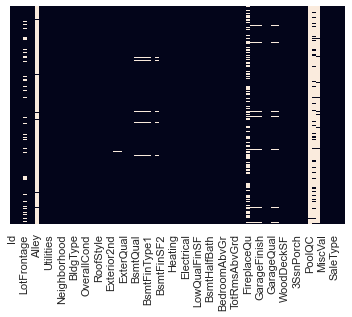

In [7]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

In [8]:
def removing_missing_data(df):
    """
    Function to remove missing data and drop the Id column.
    """
    # removing the NaNs in our categorical variables data
    list_to_be_replaced = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageCond', 'GarageType', 
                           'GarageFinish', 'GarageQual', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 
                           'BsmtFinType1', 'Electrical', 'MSZoning',  'Utilities', 'Functional', 'KitchenQual',
                           'Exterior1st', 'Exterior2nd', 'SaleType']
    
    for i in list_to_be_replaced:
        if i in (df.columns): df[i] = np.where(df[i].isna(), 'NA', df[i])
        else: pass

    # Masonry type has 'None' rather than 'NA'
    df['MasVnrType'] = np.where(df['MasVnrType'].isna(), 'None', df['MasVnrType'])

    # Removing missing data from the numerical variables data
    missing_data_is_zero = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 
                            'GarageArea', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtHalfBath']
    for i in missing_data_is_zero:
        if i in df.columns: df[i] = np.where(df[i].isna(), 0, df[i])

    # Replacing year the garage was built with the year the house was built:
    if 'GarageYrBlt' in df.columns: df['GarageYrBlt'] = np.where(df['GarageYrBlt'].isna(), df['YearBuilt'], df['GarageYrBlt'])

    # Let's also remove the Id column while we're at it:
    if 'Id' in df.columns: df.drop('Id', axis=1, inplace=True)

# Running the function:
removing_missing_data(df)

<AxesSubplot:>

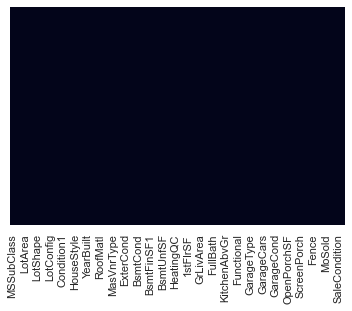

In [9]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

In [10]:
df["SqFtPerRoom"] = df["GrLivArea"] / (df["TotRmsAbvGrd"] + df["FullBath"] + df["HalfBath"] + df["KitchenAbvGr"])

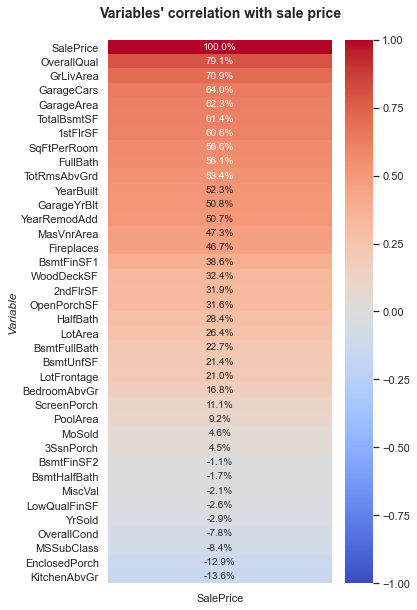

In [11]:
# Creating  a list with the names of all the columns with numeric data and remove the ID column
num_variables = df.select_dtypes([np.number]).columns.tolist()

# Calculating the correlations:
correlations = df[num_variables].corr();
# Building a large figure
plt.figure(figsize=(5,10))
# Creating my heatmap:
heatmap = sns.heatmap(correlations[['SalePrice']].sort_values(by=['SalePrice'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True,
            fmt=".1%");
heatmap.set_ylabel("Variable", fontproperties=font)
heatmap.set_title("Variables' correlation with sale price\n", fontsize=14, fontweight='bold');

In [12]:
def create_z_scores(df):
    """
    Function to create my z-scores and identify the outliers.
    """
    # First we need to ensure the columns that do not contain outliers are not affected:
    non_num_var = ['YearBuilt', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
                   'KitchenAbvGr', 'BedroomAbvGr', 'BsmtHalfBath', 'SalePrice']
    outlier_cols = set(num_variables) - set(non_num_var)
    outlier_cols = list(outlier_cols.copy()) 
    # now we have a list of the columns that may contain outliers

    # Let's calculate the z-score for every item in the df:
    z_score = (df[outlier_cols] - df[outlier_cols].mean())/df[outlier_cols].std()
    
    # And find all the outliers by column:
    outliers = z_score[z_score > 3].count().sort_values(ascending=False)

    return outlier_cols, outliers, z_score

outlier_cols, outliers, z_score = create_z_scores(df)

In [13]:
def add_value_labels(ax, labels=None, legend=None, fontsize=fontsize, label_format="{:,.0f}", spacing=1):
    """
    Function to add labels to the end of each bar in a bar chart.
    - ax (matplotlib.axes.Axes): the matplotlib object containing the axes of the plot to annotate.
    - labels (list): the labels explicitly given to the function
    - fontsize (int): chosen fontsize of the label 
    - spacing (int): the distance between the labels and the bars
    """
    
    # For each bar: Place a label
    for count, rect in enumerate(ax.patches):
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label:
        space = spacing
        # Vertical alignment for positive values:
        va = 'bottom'

        # If value of bar is negative, place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        if labels is None:
            # Use Y value as label and format number
            label = label_format.format(y_value)
        else:
            label = label_format.format(labels[count])

        # Create annotation
        ax.annotate(
            label,                          # Use `label` as label
            (x_value, y_value),             # Place label at end of the bar
            xytext=(0, space),              # Vertically shift label by `space`
            textcoords="offset points",     # Interpret `xytext` as offset in points
            fontsize=fontsize,              # Font size
            ha='center',                    # Horizontally center label
            va=va)                          # Vertically align label

In [14]:
def draw_bar_chart(x, y, title=None, x_axis_label=None, x_tick_rotation=0, alignment="center",
                   y_axis_label=None, y_tick_labels_format='{:,.0f}', y_scaling=1, y_axis_limits=None, 
                   add_num_labels=False, num_labels=None, legend=None, label_format="{:,.0f}", 
                   figsize=(20,6)
                  ):
    """
    Draws a bar chart of selected variables
    - x (list, dict): variable column name from your df
    - y (list, dict): target column name from your df
    - title (str): chart title
    - x_axis_label (str): title of x-acis
    - x_tick_rotation (int): rotation of x-axis labels in degrees
    - y_axis_label (str): title of y-axis
    - y_tick_labels_format (text format): format of y-axis labels 
    - y_scaling (int): scaling of y-axis labels, i.e. '000s, millions
    - y_axis_limits (tuple): scale of the y-axis
    - figsize (tuple of int/float): figure size
    returns: seaborn bar chart axis
    """
    
    # Chart the outputs
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    sns.barplot(x=x, y=y)
    # Set title
    ax1.set_title(title, fontsize=14, fontweight='bold')
    # Set the y-axis label
    ax1.set_ylabel(y_axis_label, fontproperties=font)
    # Format the y-axis labels
    ax1.set_ylim(y_axis_limits)
    y_tick_loc = ax1.get_yticks().tolist() # Setting the y-tick labels
    ax1.yaxis.set_major_locator(mticker.FixedLocator(y_tick_loc))
    ax1.set_yticklabels([y_tick_labels_format.format(x/y_scaling) for x in y_tick_loc])
    # Set the x-axis label
    ax1.set_xlabel(x_axis_label, fontproperties=font)
    # Format the x-axis labels
    ax1.set_xticklabels(labels=[t.get_text() for t in ax1.get_xticklabels()], rotation=x_tick_rotation, horizontalalignment=alignment);
    
    # Add value labels above bars:
    if add_num_labels == True:
        add_value_labels(ax=ax1, labels=num_labels, label_format=label_format)
    
    # Adding a legend to explain what the numbers are, if not the y value
    if legend is not None:
        ax1.text(x=0.99, y=0.97, s=legend, fontsize=fontsize, fontproperties=font, 
                 ha='right', va='top', transform=ax1.transAxes)
    return ax1

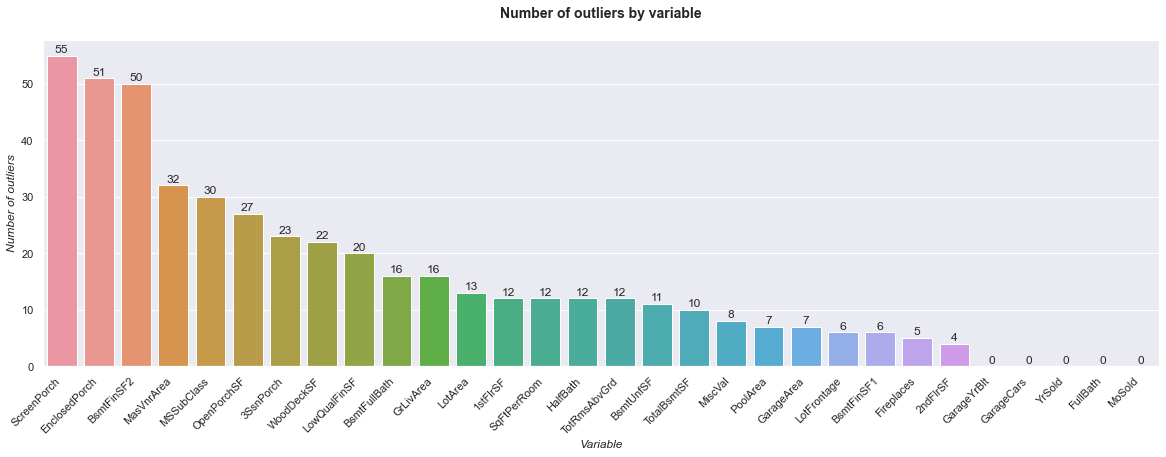

In [15]:
# Now let's graph the number of items with a z-score greater than 3 for each metric:
draw_bar_chart(x=outliers.keys(), y=outliers, title='Number of outliers by variable\n', 
               x_axis_label='Variable', x_tick_rotation=45, alignment='right',
               y_axis_label='Number of outliers', y_tick_labels_format='{:,.0f}', 
               add_num_labels=True, figsize=(20,6)
              );

In [16]:
def replace_outliers(outlier_cols, num_variables, outliers, df):
    # First up let's drop the three variables that are not useful from our dataframe...
    drop_me = []
    for idx, outlier in enumerate(outliers):
        if outlier > 40:
            drop_me.append(outliers.keys()[idx])
    print("Dropping from the data:",drop_me)
    df.drop(drop_me, axis=1, inplace=True)

    # ...and remove them from our outlier columns and our numerical variables while we're at it
    drop_me.append('MSSubClass')
    outlier_cols = [i for i in outlier_cols if i not in drop_me]
    num_variables = [i for i in num_variables if i not in drop_me]

    # Let's change the MSSubClass to strings so it is treated as a categorical variable:
    df['MSSubClass'] = df.MSSubClass.astype(str)

    # Let's replace all outliers (defined as having a z-score greater than 3) with the maximum non-outlier figure:
    max_z_score = 3
    for i in outlier_cols:
        max_value = df[i].mean() + max_z_score*(df[i].std())
        df.loc[df[i] > max_value, i] = max_value
    
    return drop_me

drop_me = replace_outliers(outlier_cols, num_variables, outliers, df)

Dropping from the data: ['ScreenPorch', 'EnclosedPorch', 'BsmtFinSF2']


In [17]:
# Saving our correlations from before:
correlations_old = correlations[num_variables].copy()
correlations_old.drop(drop_me, axis=0, inplace=True)

# Creating  a list with the names of all the columns with numerical data
num_variables = df.select_dtypes([np.number]).columns.tolist()

# Calculating the new correlations:
correlations_new = df[num_variables].corr();

# Checking the difference between the two correlations:
delta_corr = correlations_new['SalePrice'] - correlations_old['SalePrice']

# Removing elements with no change:
to_drop = delta_corr[delta_corr == 0].index
delta_corr.drop(to_drop, inplace=True)
delta_corr.sort_values(ascending=False, inplace=True)

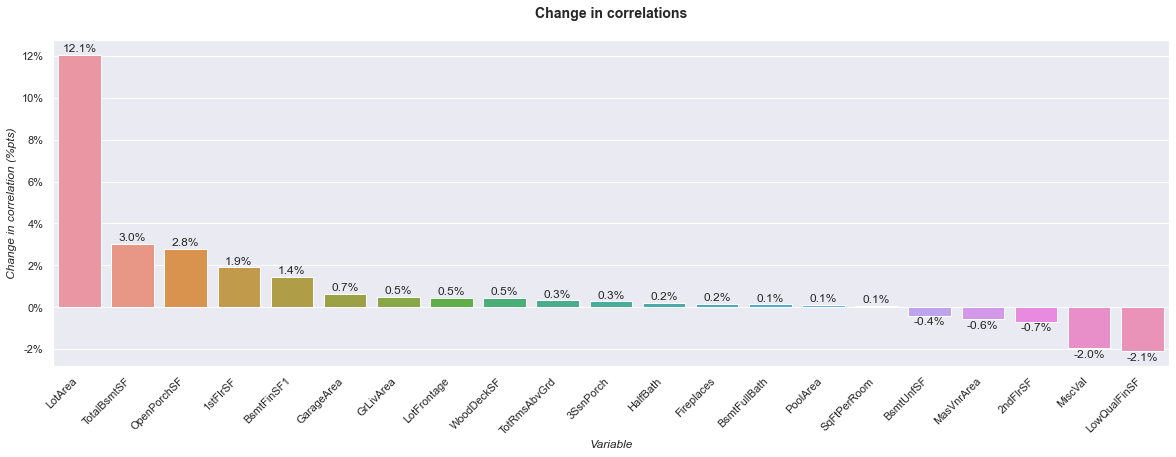

In [18]:
draw_bar_chart(x=delta_corr.index, y=delta_corr, title='Change in correlations\n', 
               x_axis_label='Variable', x_tick_rotation=45, alignment='right',
               y_axis_label='Change in correlation (%pts)', y_tick_labels_format='{:0.0%}', 
               add_num_labels=True, label_format="{:0.1%}", figsize=(20,6)
              );

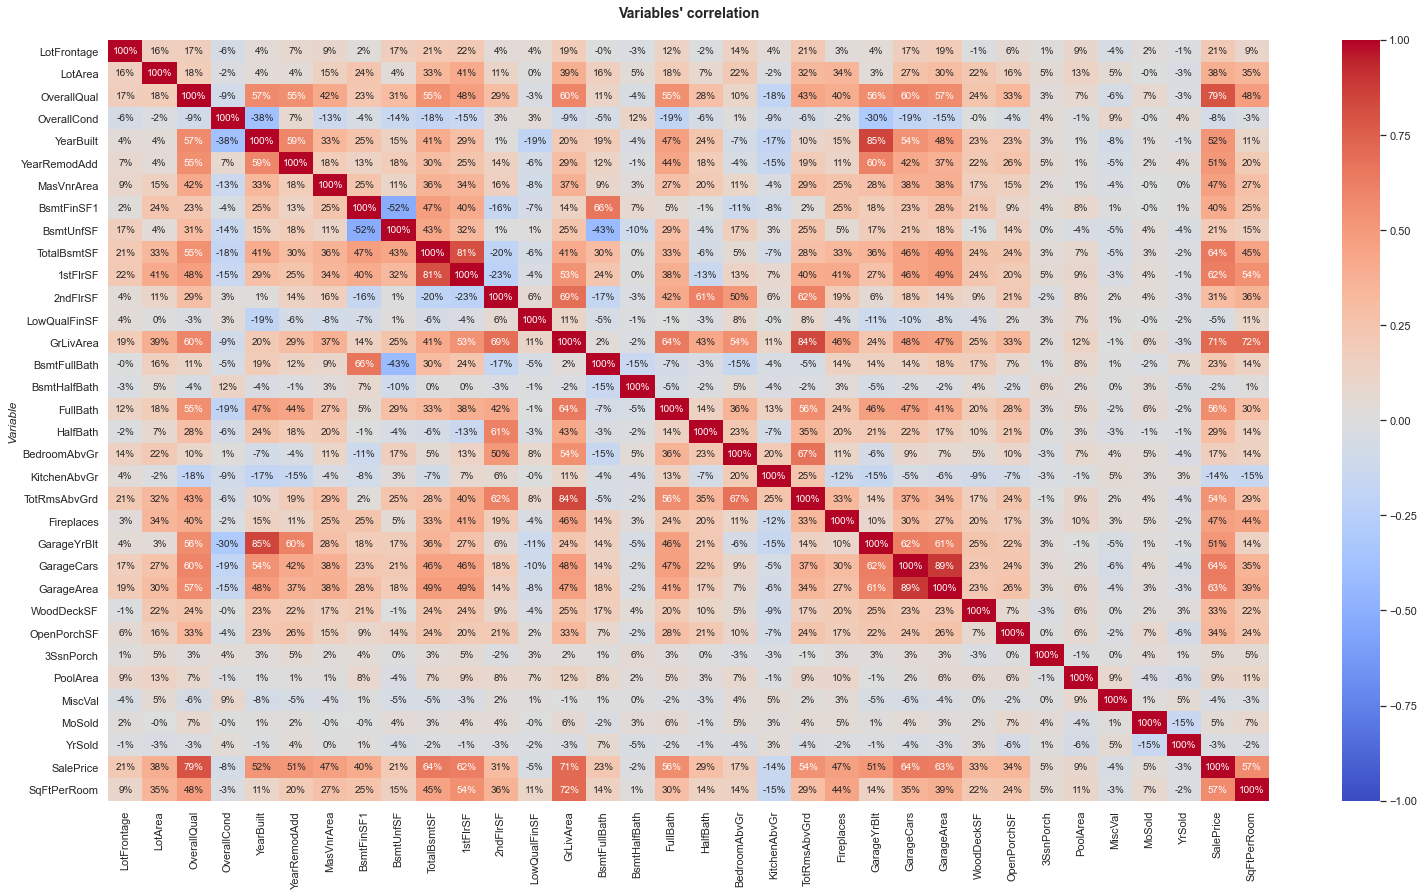

In [19]:
# Recalculating the correlations:
correlations = df[num_variables].corr();
# Building a large figure
plt.figure(figsize=(26,14))
# Creating my heatmap:
heatmap = sns.heatmap(correlations,
            vmin=-1,
            cmap='coolwarm',
            annot=True,
            fmt=".0%");
heatmap.set_ylabel("Variable", fontproperties=font)
heatmap.set_title("Variables' correlation\n", fontsize=14, fontweight='bold');

In [20]:
# Feature selection class to eliminate multicollinearity
class MultiCollinearityEliminator():
    
    # Class constructor
    def __init__(self, df, target, threshold):
        self.df = df
        self.target = target
        self.threshold = threshold

    # Method to create and return the feature correlation matrix dataframe
    def createCorrMatrix(self, include_target=False):
        # Checking we should include the target in the correlation matrix
        if (include_target == False):
            df_temp = self.df.drop([self.target], axis =1)
            
            # Setting method to Pearson to prevent issues in case the default method for df.corr() gets changed.
            # Setting min_period to 30 for the sample size to be statistically significant (normal) according to central limit theorem.
            corrMatrix = df_temp.corr(method='pearson', min_periods=30).abs()
        
        # Target is included to create the series of feature to target correlation. - Please refer the notes under the 
        # print statement to understand why we create the series of feature to target correlation
        elif (include_target == True):
            corrMatrix = self.df.corr(method='pearson', min_periods=30).abs()
        return corrMatrix

    # Method to create and return the feature to target correlation matrix dataframe
    def createCorrMatrixWithTarget(self):
        """After obtaining the list of correlated features, this method will help to view which variables (in the list of correlated features) 
        are least correlated with the target. This way, out of the list of correlated features, we can ensure to eliminate the feature that is 
        least correlated with the target. This not only helps to sustain the predictive power of the model but also helps in reducing model complexity."""
        
        # Obtaining the correlation matrix of the dataframe (along with the target)
        corrMatrix = self.createCorrMatrix(include_target = True)                           
        # Creating the required dataframe, then dropping the target row and sorting by the value of correlation with target (in asceding order)
        corrWithTarget = pd.DataFrame(corrMatrix.loc[:,self.target]).drop([self.target], axis = 0).sort_values(by = self.target)                    
        #print("corrWithTarget is:\n",corrWithTarget, '\n')
        return corrWithTarget

    # Method to create and return the list of correlated features
    def createCorrelatedFeaturesList(self):
        # Obtaining the correlation matrix of the dataframe (without the target)
        corrMatrix = self.createCorrMatrix(include_target = False)                          
        colCorr = []
        # Iterating through the columns of the correlation matrix dataframe
        for column in corrMatrix.columns:
            # Iterating through the values (row wise) of the correlation matrix dataframe
            for idx, row in corrMatrix.iterrows():                                            
                if(row[column]>self.threshold) and (row[column]<1):
                    # Adding the features that are not already in the list of correlated features
                    if (idx not in colCorr):
                        colCorr.append(idx)
                    if (column not in colCorr):
                        colCorr.append(column)
        to_print = ""
        for idx, feat in enumerate(colCorr):
            if idx == 0: to_print += " - "+feat
            else: to_print += ", "+feat
        if colCorr == []: print("No more correlated features!")
        else: print("Correlated features are:\n",to_print)
        return colCorr

    # Method to eliminate the least important features from the list of correlated features
    def deleteFeatures(self, colCorr):
        # Obtaining the feature to target correlation matrix dataframe
        corrWithTarget = self.createCorrMatrixWithTarget()                                  
        deleted_columns = []
        for idx, row in corrWithTarget.iterrows():
            #print("idx is: ",idx, '\n')
            if (idx in colCorr):
                self.df = self.df.drop(idx, axis = 1)
                print("Deleting: "+idx+"\n")
                deleted_columns.append(idx)
                break
        return self.df, deleted_columns

    # Method to run automatically eliminate multicollinearity
    def autoEliminateMulticollinearity(self):
        # Obtaining the list of correlated features
        colCorr = self.createCorrelatedFeaturesList()                                       
        while colCorr != []:
            # Obtaining the dataframe after deleting the feature (from the list of correlated features) that is least correlated with the taregt
            self.df, deleted_columns = self.deleteFeatures(colCorr)
            # Obtaining the list of correlated features
            colCorr = self.createCorrelatedFeaturesList()                                     
        return self.df, deleted_columns

In [21]:
threshold = 0.65
mce = MultiCollinearityEliminator(df=df, target='SalePrice', threshold=threshold)
df, deleted_columns = mce.autoEliminateMulticollinearity()

Correlated features are:
  - GarageYrBlt, YearBuilt, BsmtFullBath, BsmtFinSF1, 1stFlrSF, TotalBsmtSF, GrLivArea, 2ndFlrSF, TotRmsAbvGrd, SqFtPerRoom, BedroomAbvGr, GarageArea, GarageCars
Deleting: BedroomAbvGr

Correlated features are:
  - GarageYrBlt, YearBuilt, BsmtFullBath, BsmtFinSF1, 1stFlrSF, TotalBsmtSF, GrLivArea, 2ndFlrSF, TotRmsAbvGrd, SqFtPerRoom, GarageArea, GarageCars
Deleting: BsmtFullBath

Correlated features are:
  - GarageYrBlt, YearBuilt, 1stFlrSF, TotalBsmtSF, GrLivArea, 2ndFlrSF, TotRmsAbvGrd, SqFtPerRoom, GarageArea, GarageCars
Deleting: 2ndFlrSF

Correlated features are:
  - GarageYrBlt, YearBuilt, 1stFlrSF, TotalBsmtSF, TotRmsAbvGrd, GrLivArea, SqFtPerRoom, GarageArea, GarageCars
Deleting: GarageYrBlt

Correlated features are:
  - 1stFlrSF, TotalBsmtSF, TotRmsAbvGrd, GrLivArea, SqFtPerRoom, GarageArea, GarageCars
Deleting: TotRmsAbvGrd

Correlated features are:
  - 1stFlrSF, TotalBsmtSF, SqFtPerRoom, GrLivArea, GarageArea, GarageCars
Deleting: SqFtPerRoom

Correl

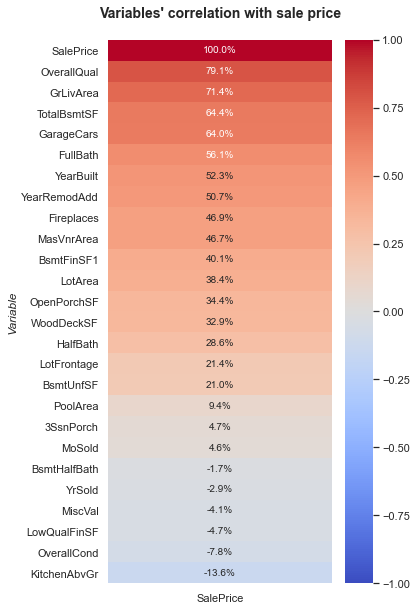

In [22]:
# Creating  a list with the names of all the columns with numeric data and remove the ID column
num_variables = df.select_dtypes([np.number]).columns.tolist()
# Recalculating the correlations:
correlations = df[num_variables].corr();
# Draw the heatmap
plt.figure(figsize=(5,10))
heatmap = sns.heatmap(correlations[['SalePrice']].sort_values(by=['SalePrice'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True,
            fmt=".1%");
heatmap.set_ylabel("Variable", fontproperties=font)
heatmap.set_title("Variables' correlation with sale price\n", fontsize=14, fontweight='bold');

In [23]:
# Dropping variables with correlations less than 20%
min_correlation = 0.2
delete_me = []
for i in range(0, len(correlations)):
    if correlations['SalePrice'][i] < min_correlation: delete_me.append(correlations['SalePrice'].keys()[i])
print("Dropping the following variables from the data with correlation below "+str("{:.0%}".format(min_correlation))+":\n",delete_me)
df.drop(delete_me, axis=1, inplace=True)

Dropping the following variables from the data with correlation below 20%:
 ['OverallCond', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 61 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   float64
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

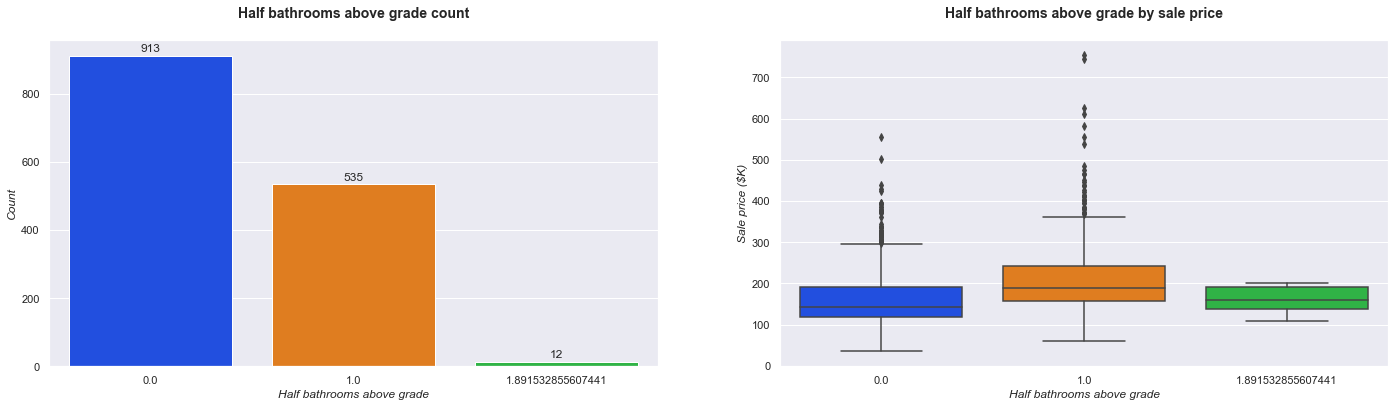

In [25]:
def graph_overview(column, title, x_label_format='{:,.0f}', y_label_format='{:,.0f}', continuous=False, rotation=0, alignment='center'):
    """
    Short function to return a count and distribution plot of the metric. 
    - column (string) is the column name of the metric to be analysed
    - title (string) title of the graph
    - continuous (bool) whether the variable is continuous
    - returns two charts 
    """
    
    # Format the fonts
    font = FontProperties(size=fontsize, style='italic')
    
    # Set the figure up
    fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(24,6))
    
    if continuous:
        # Histogram
        graph1 = sns.histplot(x=df[column], ax=ax1)
        ax1.set_title(title+' histogram\n', fontsize=14, fontweight='bold')
        
        # Scatterplot
        slope, intercept, r_value, pv, se = stats.linregress(x=df[column], y=df['SalePrice'])
        graph2 = sns.regplot(data=df, x=column, y='SalePrice', ci=99, ax=ax2, 
                             line_kws={"color": "red", 'label':"y={:,.0f}x+{:,.0f}".format(slope,intercept)}, 
                            ).legend(loc="best")
        ax2.set_title(title+' vs. sale price\n', fontsize=14, fontweight='bold')
        ax2.legend()
        
        # Setting the x-tick labels
        x_tick_labels = ax1.get_xticks().tolist()
        # Setting the x-tick label locations
        ax1.xaxis.set_major_locator(mticker.FixedLocator(x_tick_labels)) 
        ax2.xaxis.set_major_locator(mticker.FixedLocator(x_tick_labels)) 
        # Setting the x-label format
        ax1.set_xticklabels([x_label_format.format(x) for x in x_tick_labels]) 
        ax2.set_xticklabels([x_label_format.format(x) for x in x_tick_labels])
    
    else:
        # Setting the order the graphs category labels
        x_labels = df[column].value_counts().keys() 
        
        # Countplot
        graph1 = sns.countplot(x=df[column], ax=ax1, order=x_labels)
        ax1.set_title(title+' count\n', fontsize=14, fontweight='bold')
        add_value_labels(ax1, spacing=2)  # Adds the values above the bars
        
        # Boxplot
        graph2 = sns.boxplot(data=df, x=column, y='SalePrice', ax=ax2, order=x_labels)#, orient='h')
        ax2.set_title(title+' by sale price\n', fontsize=14, fontweight='bold')
        
        # Setting x-tick labels
        ax1.set_xticklabels(labels=x_labels, rotation=rotation, horizontalalignment=alignment)
        ax2.set_xticklabels(labels=x_labels, rotation=rotation, horizontalalignment=alignment)
        
    # Setting axis labels    
    ax1.set_xlabel(title, fontproperties=font)
    ax1.set_ylabel('Count', fontproperties=font)
    ax2.set_xlabel(title, fontproperties=font)
    ax2.set_ylabel('Sale price ($K)', fontproperties=font) 
    
    # Setting y-tick labels
    y_tick_labels_1 = ax1.get_yticks().tolist() # Setting the y-tick labels
    ax1.yaxis.set_major_locator(mticker.FixedLocator(y_tick_labels_1)) # Setting the y-tick label locations
    ax1.set_yticklabels([y_label_format.format(x) for x in y_tick_labels_1]) # Setting the y-label format
    
    y_tick_loc_2 = ax2.get_yticks().tolist() # Setting the y-tick labels
    ax2.yaxis.set_major_locator(mticker.FixedLocator(y_tick_loc_2))
    ax2.set_yticklabels([y_label_format.format(x/1000) for x in y_tick_loc_2])
graph_overview('HalfBath', 'Half bathrooms above grade', continuous=False)

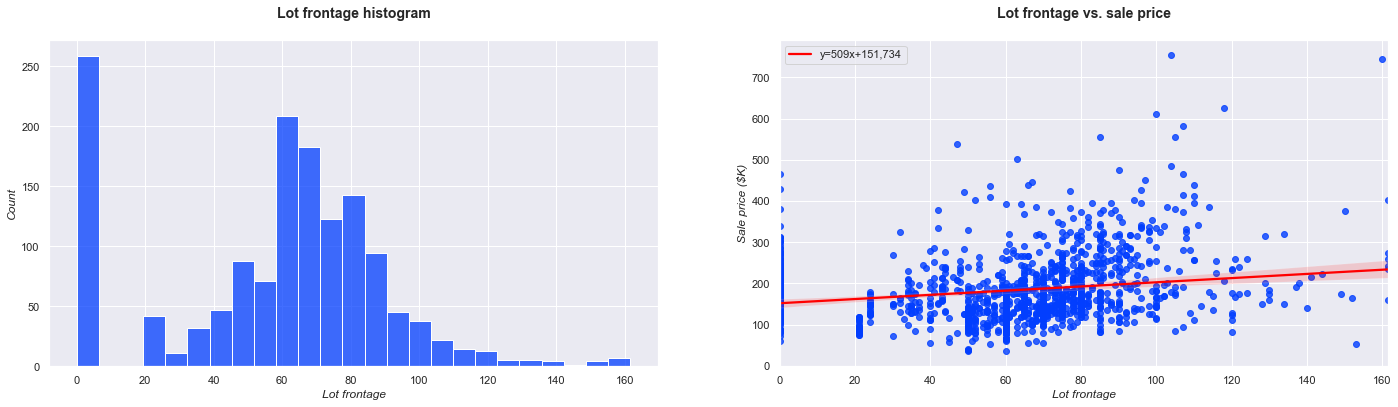

In [26]:
df['HalfBath'] = np.where(df['HalfBath'] == 1.8915328556074589, 1, df['HalfBath'])
graph_overview('LotFrontage', 'Lot frontage', continuous=True)

In [27]:
df.drop('LotFrontage', axis=1, inplace=True)
df.drop('BsmtUnfSF', axis=1, inplace=True)


In [28]:
def remove_correlated_weak_predictors(df=df, target='SalePrice', strong_pred_level=0.5):
    """
    Function to remove weak predictive variables which have greater correlation with strong predictors than target
    - df (dataframe): dataframe object
    - target (str): target variable
    - strong_pred_level (float): level of correlation at which a variable is defined as a strong predictor
    returns: list of strong predictors
    """
    
    # Selecting the strong predictors:
    strong_predictors = []
    for idx, var in enumerate(correlations[target]):
        if var >= strong_pred_level: strong_predictors.append(correlations[target].keys()[idx])
    strong_predictors.remove(target)
    print("Strong predictors are:", strong_predictors)

    # Re-calculating our numerical variables:
    num_variables = df.select_dtypes([np.number]).columns.tolist()

    # Checking which of the numerical variables have correlations with the strong predictors higher than sale price:
    for variable in num_variables:
        # What is the variable's correlation with sale price?
        sale_price_corr = correlations.SalePrice[variable]
        #print(variable+"'s correlation with sale price is:\t"+str("{:.0%}".format(sale_price_corr)))

        # Calculating the variables correlation with each of the strong predictors
        strong_var_predictor_corrs = []
        for strong_predictor in strong_predictors:
            if variable in strong_predictors: pass
            else: strong_var_predictor_corrs.append(correlations[variable][strong_predictor])

        # Removing variables where correlation with a strong predictor is higher than with sale price
        for idx, svp in enumerate(strong_var_predictor_corrs):
            if sale_price_corr < svp:
                output1 = str("{:.0%}".format(sale_price_corr))
                output2 = str("{:.0%}".format(svp))
                output3 = strong_predictors[idx]
                print("Dropping "+variable+" as correlation of "+output1
                      +" with target ("+target+") is lower than "+output2
                      +" correlation with strong predictor, "+output3)
                if variable in df.columns: df.drop(variable, axis=1, inplace=True)
    
    return strong_predictors
strong_predictors = remove_correlated_weak_predictors(df=df, target='SalePrice', strong_pred_level=0.5);

Strong predictors are: ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'GarageCars']
Dropping LotArea as correlation of 38% with target (SalePrice) is lower than 39% correlation with strong predictor, GrLivArea
Dropping BsmtFinSF1 as correlation of 40% with target (SalePrice) is lower than 47% correlation with strong predictor, TotalBsmtSF
Dropping HalfBath as correlation of 29% with target (SalePrice) is lower than 43% correlation with strong predictor, GrLivArea


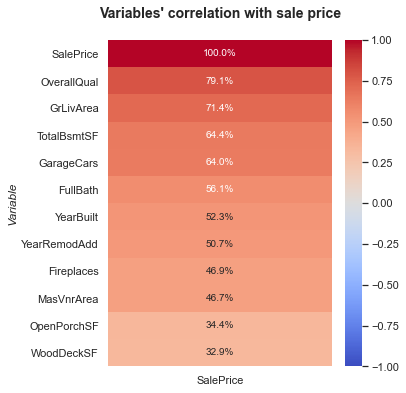

In [29]:
# Adding sale price back in and recalculating the correlations:
correlations = df.corr();
# Draw the heatmap
plt.figure(figsize=(5,6))
heatmap = sns.heatmap(correlations[['SalePrice']].sort_values(by=['SalePrice'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True,
            fmt=".1%");
heatmap.set_ylabel("Variable", fontproperties=font)
heatmap.set_title("Variables' correlation with sale price\n", fontsize=14, fontweight='bold');

In [30]:
num_variables = df.select_dtypes([np.number]).columns.tolist()
num_variables.remove('SalePrice')
print("There are "+str(len(num_variables))+" numerical variables. These are:",num_variables)

There are 11 numerical variables. These are: ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF']


In [31]:
cat_variables = df.columns.tolist()
cat_variables = [i for i in cat_variables if i not in num_variables]
cat_variables.remove('SalePrice')
print("Number of categorical variables: "+str(len(cat_variables)))

Number of categorical variables: 44


In [32]:
# Create empty lists
cat_variables_range = []
range_low = []

# Set number of occurences required to be included in the analysis below:
min_occurences = 100

# Add the difference between the dearest and cheapest groups of variables to our empty list
for i in cat_variables:
    # Create a series with the category grouped by median sale price
    group_prices = df.groupby(i)['SalePrice'].median().sort_values()
    
    # Remove the categories with fewer than x occurences 
    to_drop = []
    for count, j in enumerate(group_prices):
        item = group_prices.keys()[count]
        count = len(df[df[i]==item])
        if count < min_occurences:
            to_drop.append(item)
    
    # Now dropping all the items
    group_prices.drop(labels=to_drop, axis=0, inplace=True)
    
    # Find the range in price between the highest and lowest price:
    if len(group_prices)<2:
        price_range = 0
        range_low.append(0)
    else:
        price_range = group_prices[-1] - group_prices[0]
        # Find the lowest number of properties in the highest or lowest priced category
        low = float('inf')
        check = [0,-1]
        for k in check:
            count = len(df[df[i]==group_prices.keys()[k]])
            if count < low:
                low = count
        range_low.append(low)
    
    # Add to our lists:
    cat_variables_range.append(price_range)

# Create a dataframe with the categorical names:
cat_var_df = pd.DataFrame({'Variable': cat_variables,'SalePriceRange': cat_variables_range, 'Low':range_low})
cat_var_df.sort_values(by='SalePriceRange', axis=0, ascending=False, inplace=True)
cat_var_df.reset_index(inplace=True, drop=True)

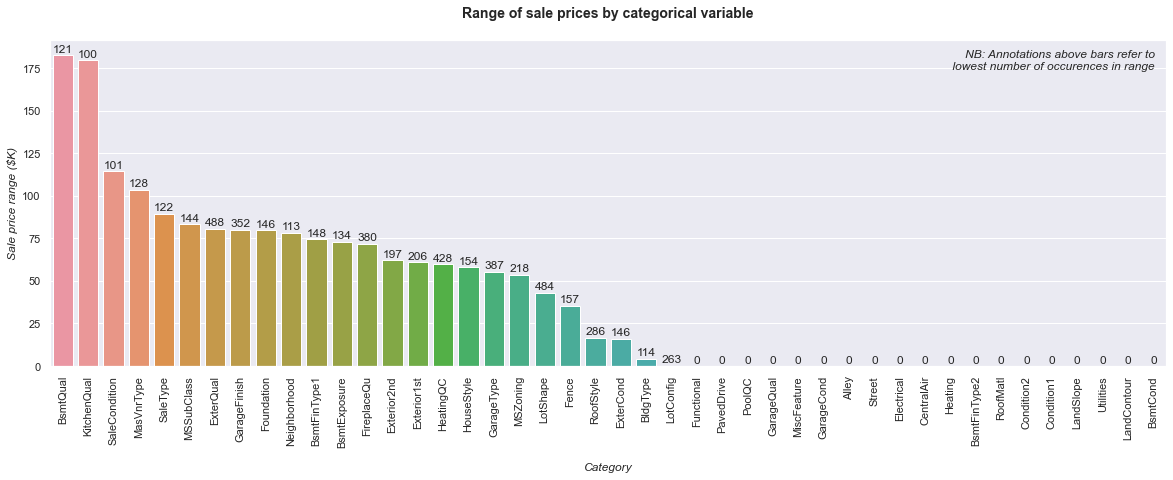

In [33]:
draw_bar_chart(x = cat_var_df['Variable'], y=cat_var_df['SalePriceRange'], title="Range of sale prices by categorical variable\n", 
               x_axis_label="\nCategory", x_tick_rotation=90, y_axis_label="Sale price range ($K)", y_scaling=1000,
               add_num_labels=True, num_labels=cat_var_df['Low'], legend='NB: Annotations above bars refer to\n lowest number of occurences in range');

In [34]:
def remove_low_occurances(df=df, low_occurence=50, cat_variables=cat_variables):
    # Defining a function to replace the variables with few occurences as 
    # 'Other', with the exception of neighbourhood
    cat_variables.remove('Neighborhood')
    for i in cat_variables:
        variable_occ = df[i].value_counts()
        for j, k in zip(variable_occ, variable_occ.keys()):
            if j < low_occurence:
                df[i] = np.where(df[i] == k, 'Other', df[i])
    cat_variables.append('Neighborhood')
    
    # Remove variables without more than a single item with more than the required number of occurences:
    var_to_remove = cat_var_df.loc[cat_var_df['Low'] < min_occurences, 'Variable'].iloc[:]
    df.drop(labels=var_to_remove, axis=1, inplace=True)
    print("Variables to be removed are:\n",var_to_remove)
    return df, cat_variables, var_to_remove

df, cat_variables, var_to_remove = remove_low_occurances(df=df, low_occurence=50, cat_variables=cat_variables)

Variables to be removed are:
 25      Functional
26      PavedDrive
27          PoolQC
28      GarageQual
29     MiscFeature
30      GarageCond
31           Alley
32          Street
33      Electrical
34      CentralAir
35         Heating
36    BsmtFinType2
37        RoofMatl
38      Condition2
39      Condition1
40       LandSlope
41       Utilities
42     LandContour
43        BsmtCond
Name: Variable, dtype: object


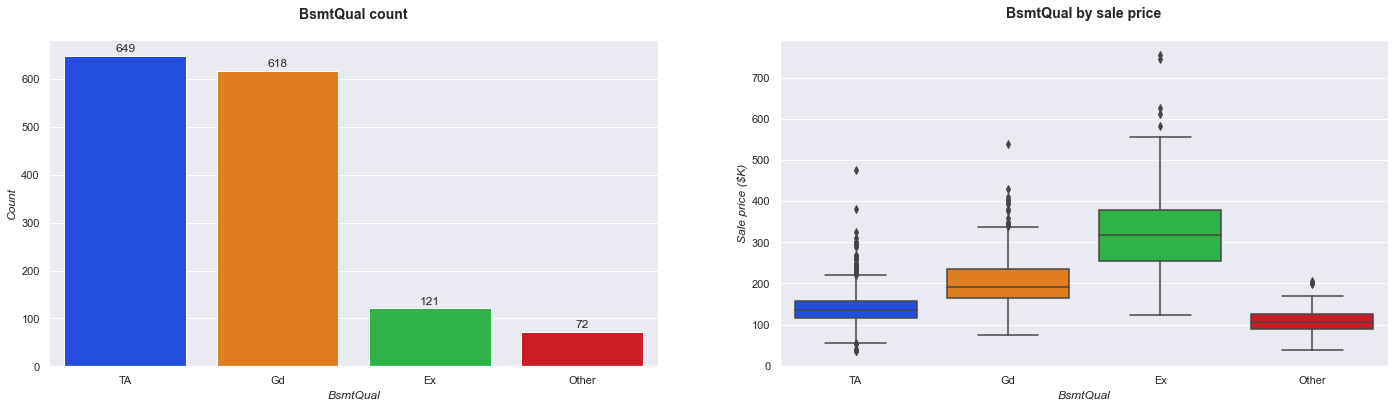

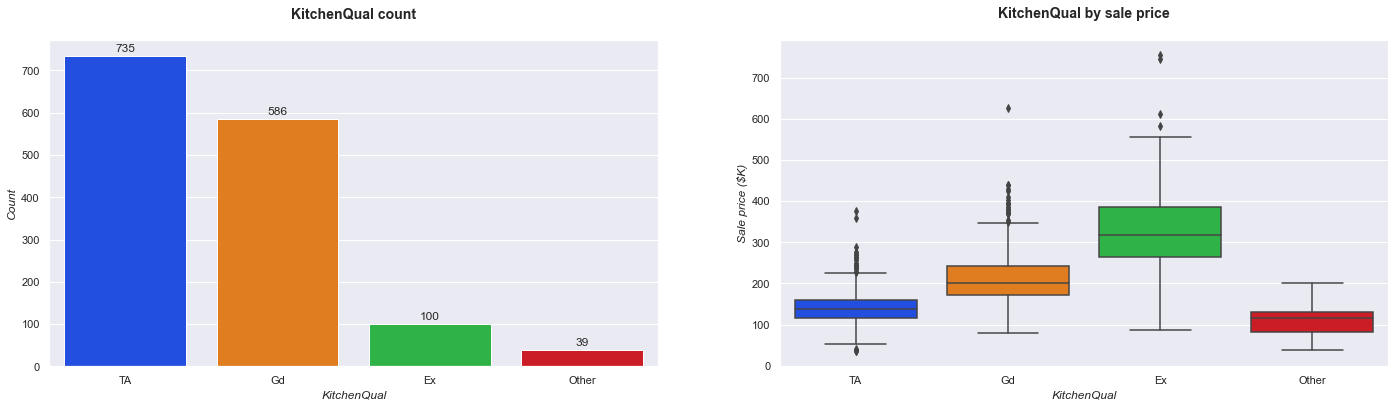

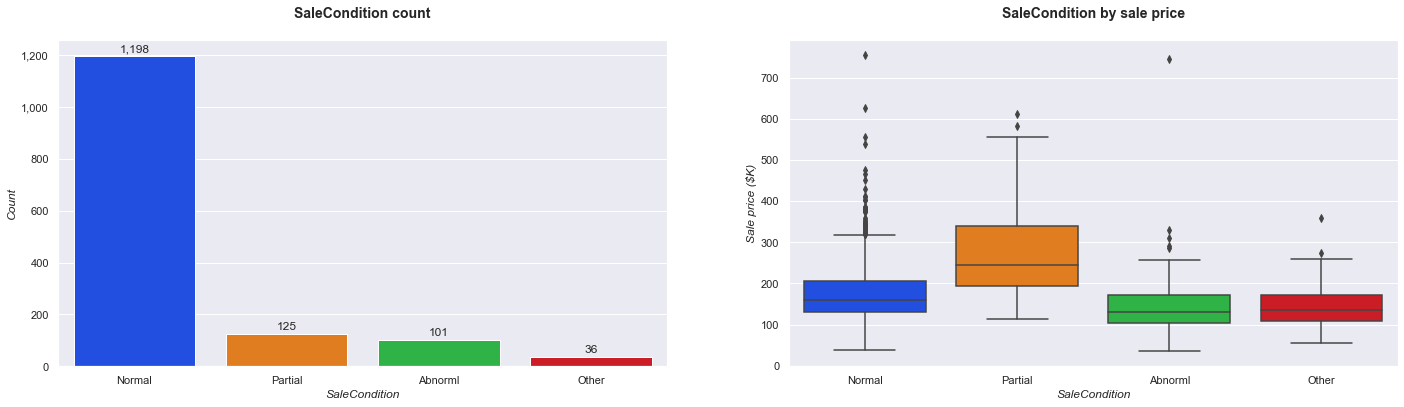

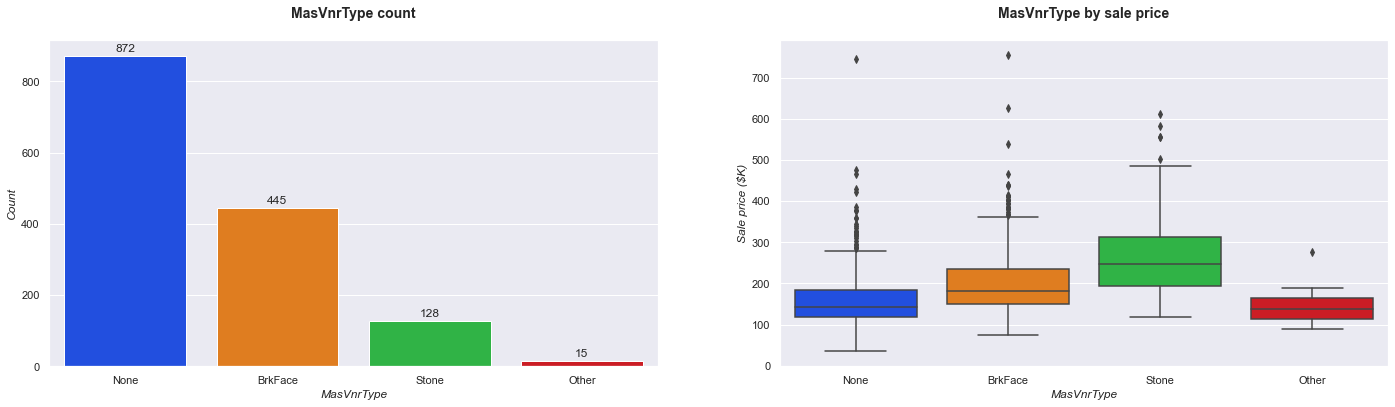

In [35]:
top_cat_var = cat_var_df[cat_var_df['SalePriceRange']>100000]
top_cat_var = top_cat_var['Variable'].tolist()
for variable in top_cat_var:
    if variable == 'Neighborhood': graph_overview(variable, variable, rotation=45, alignment='right')
    else: graph_overview(variable, variable)

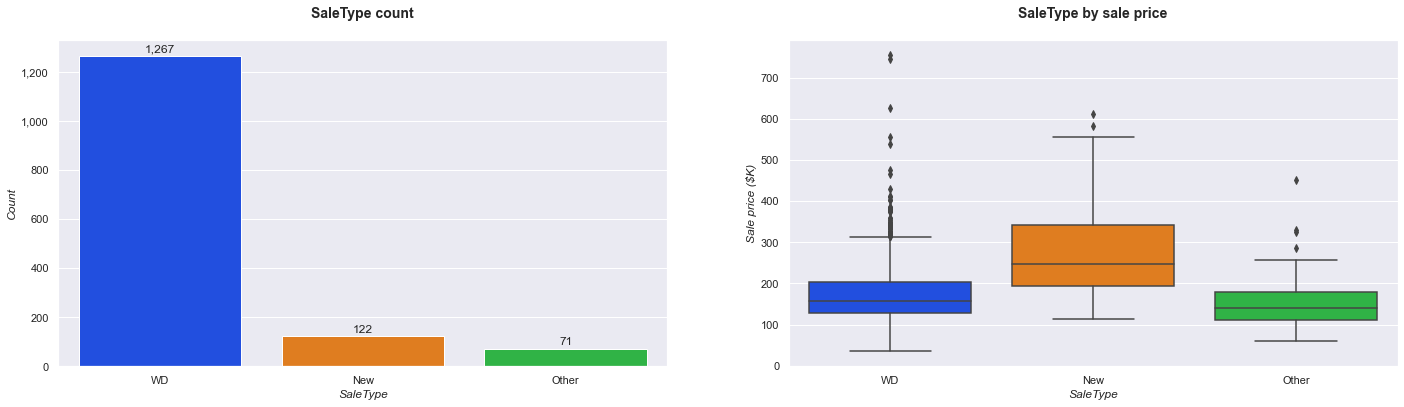

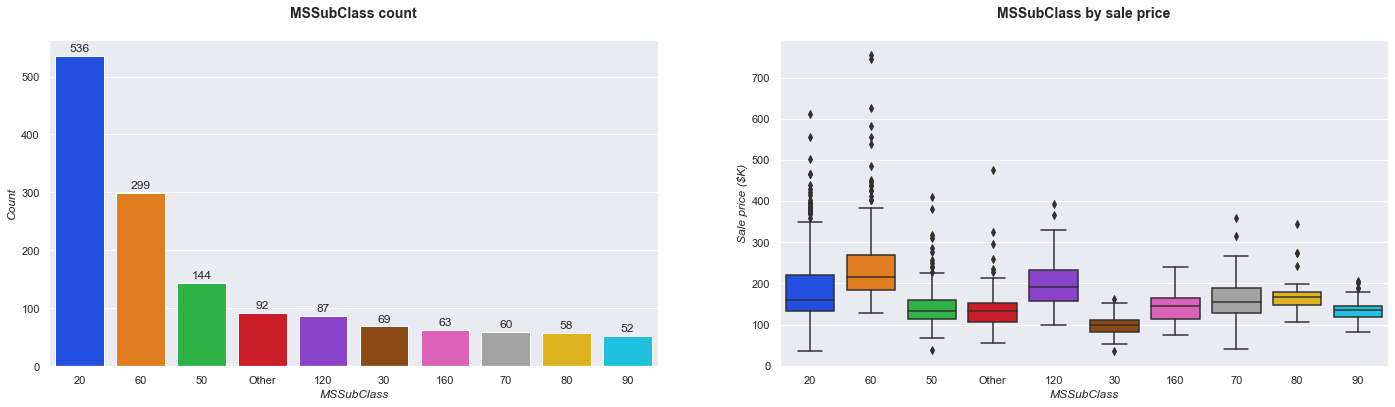

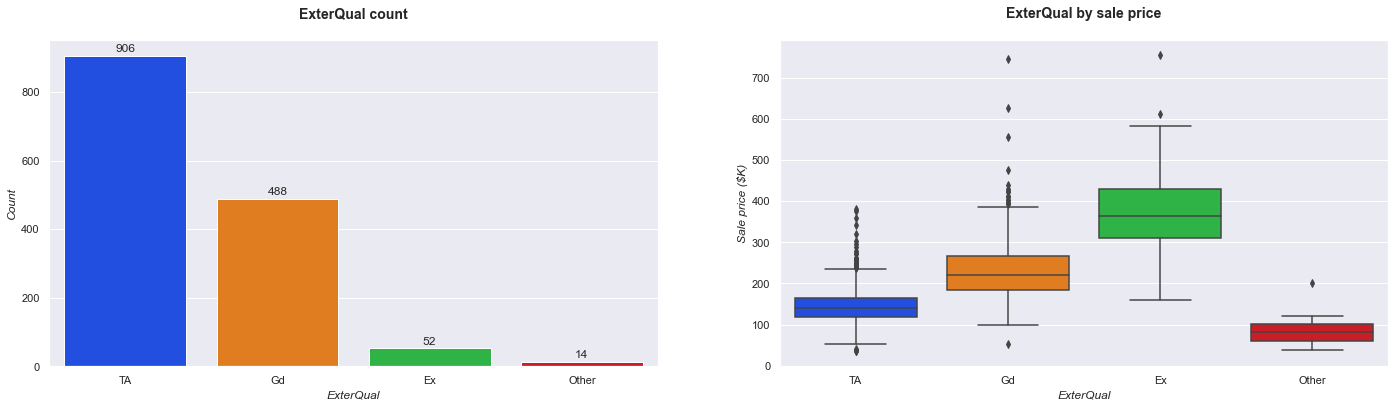

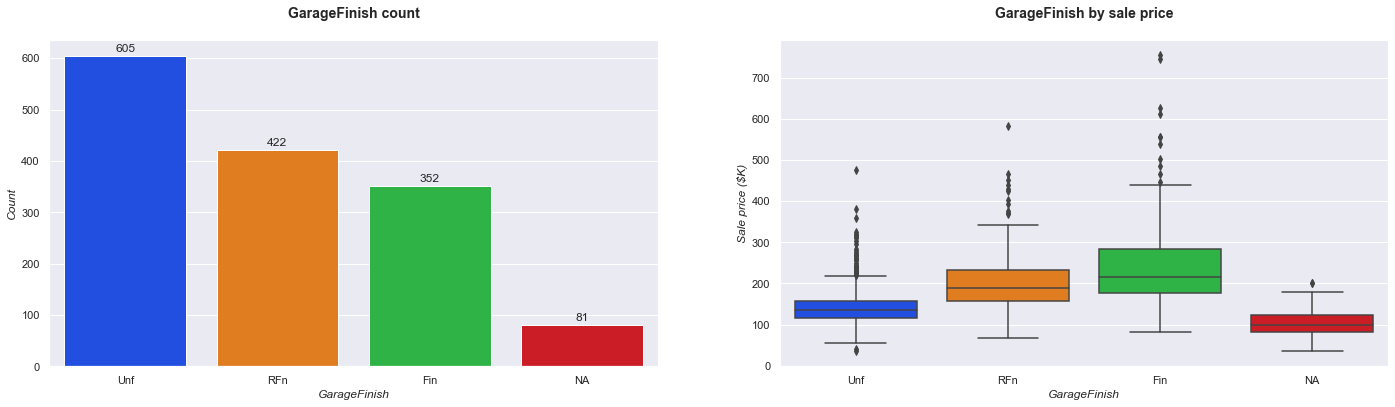

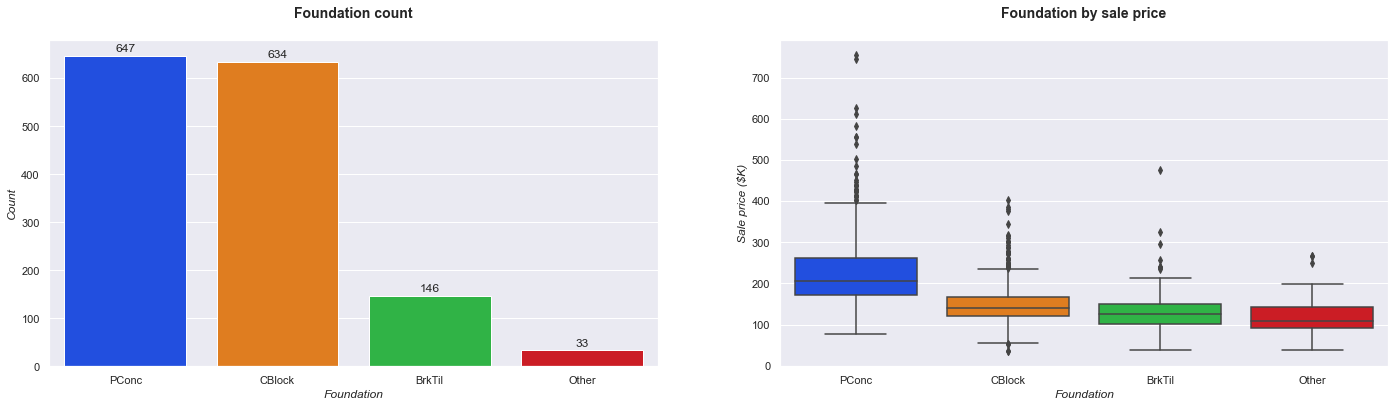

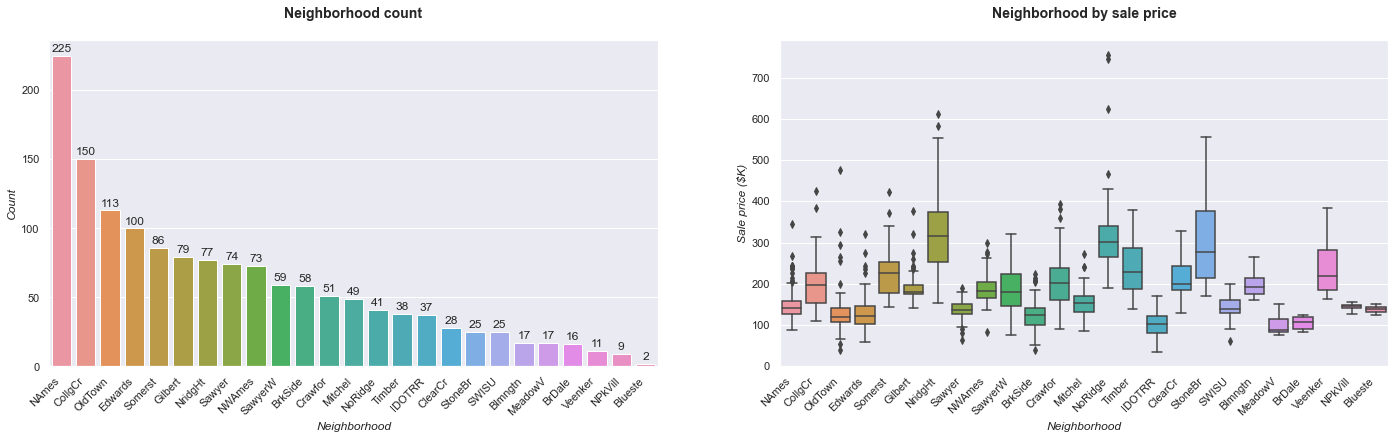

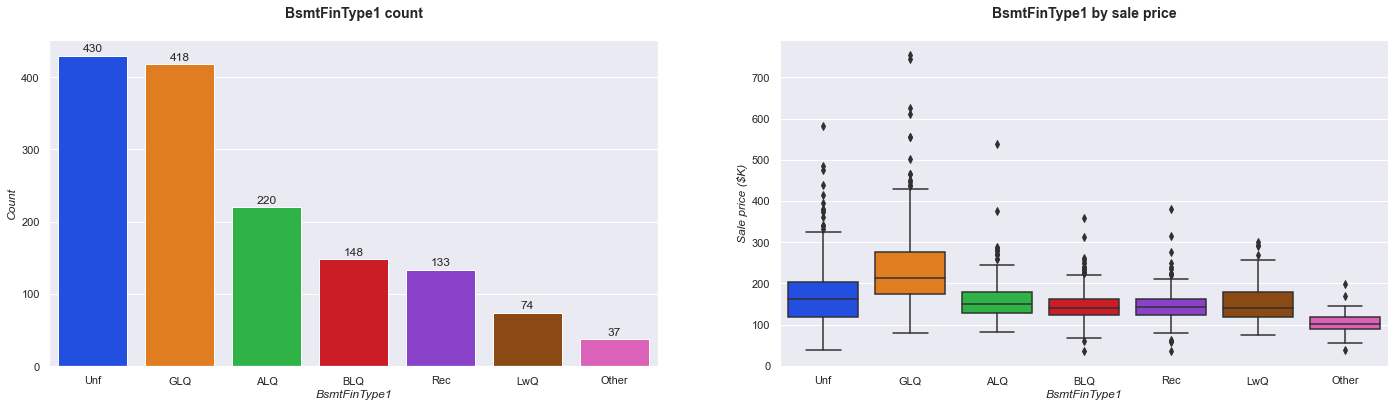

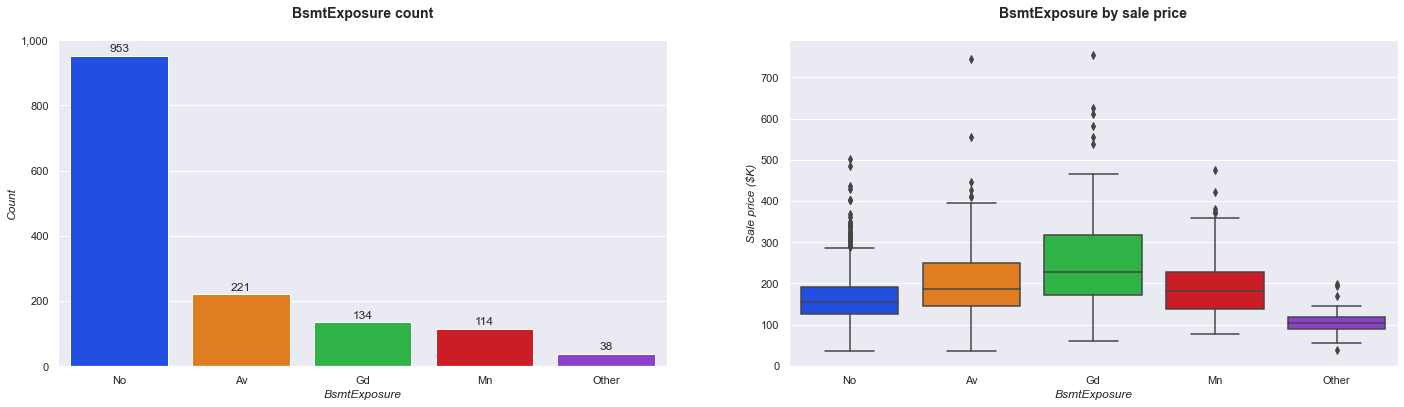

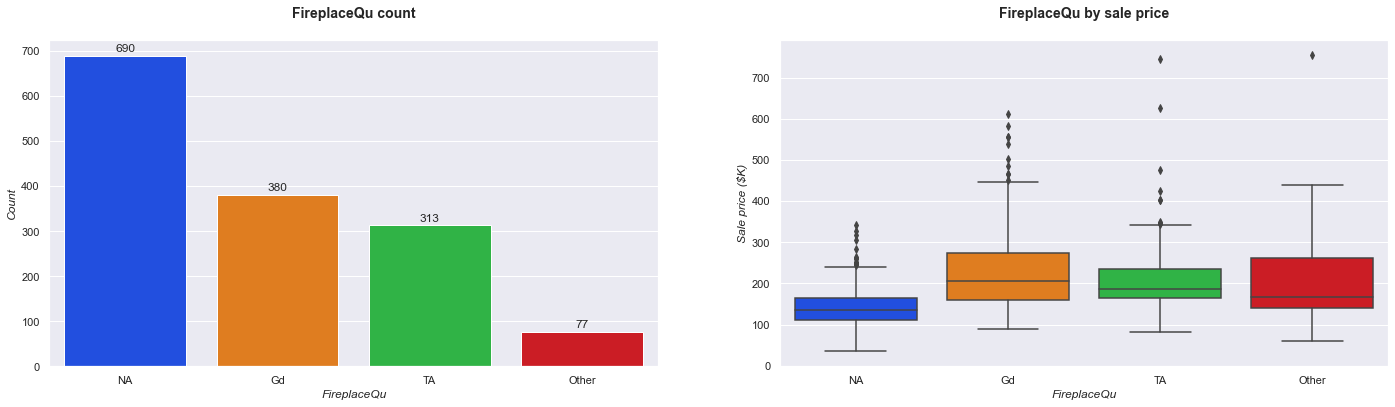

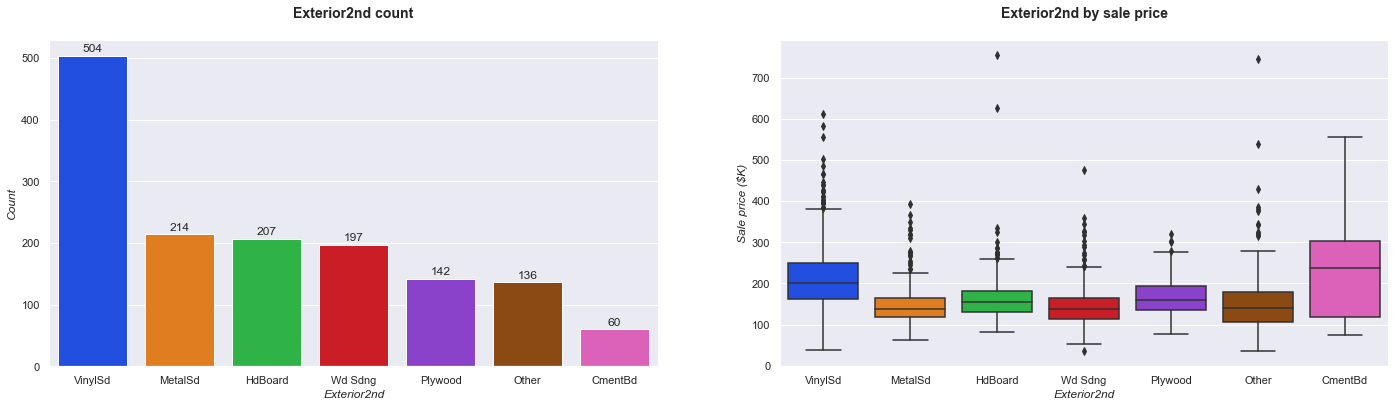

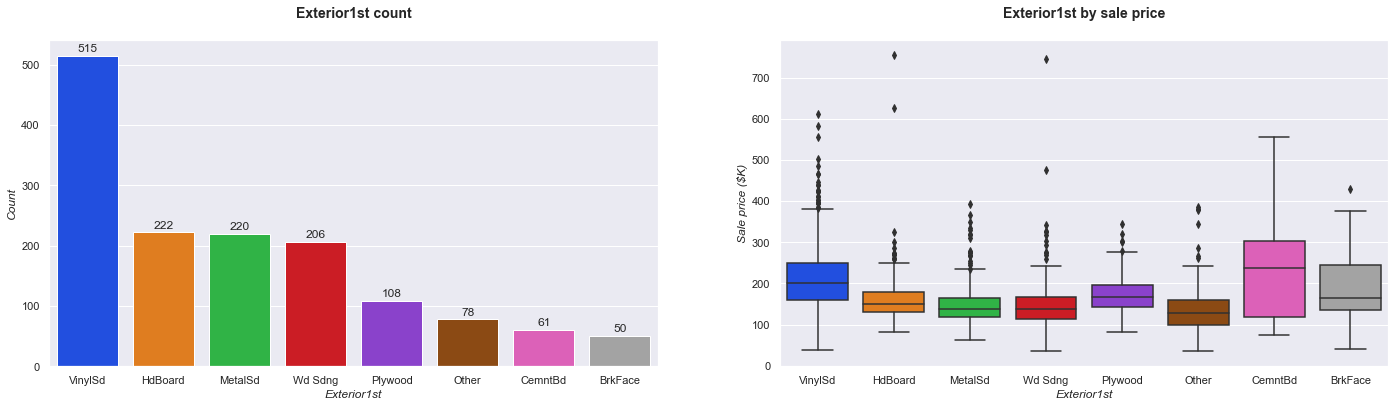

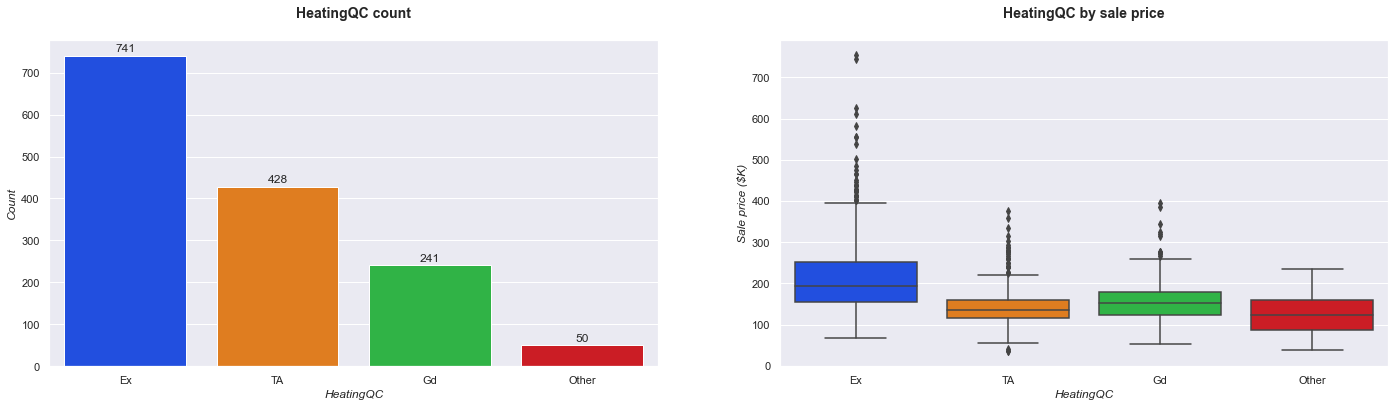

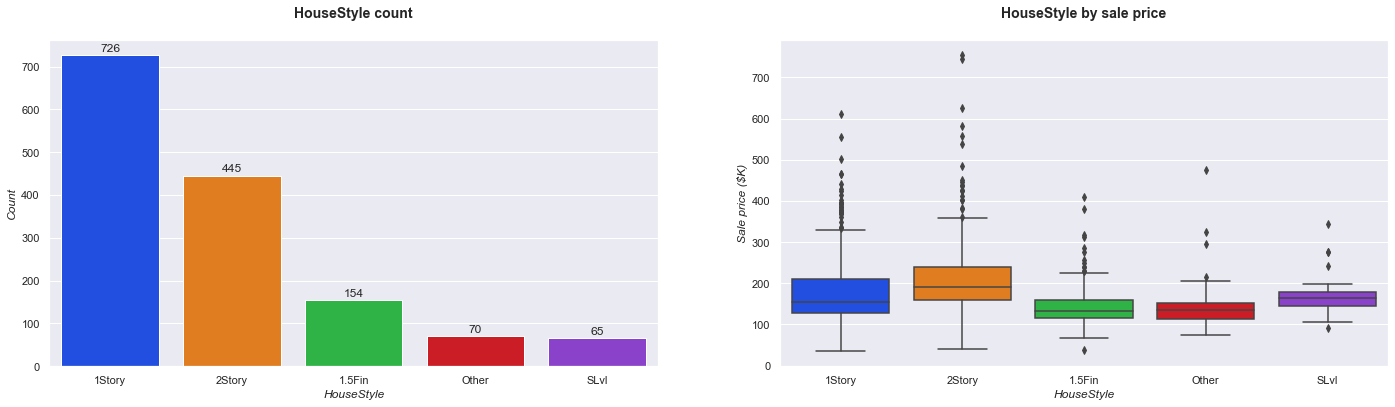

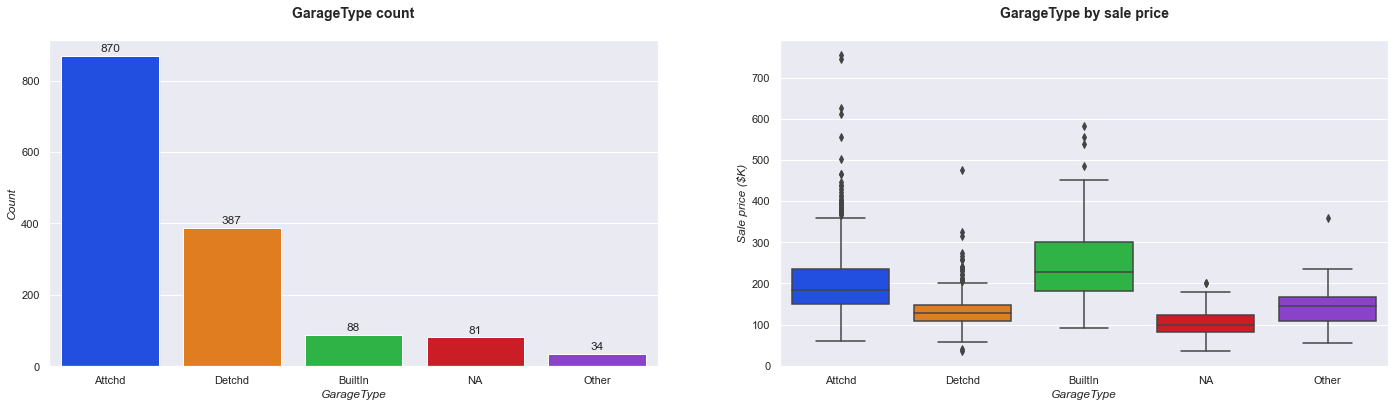

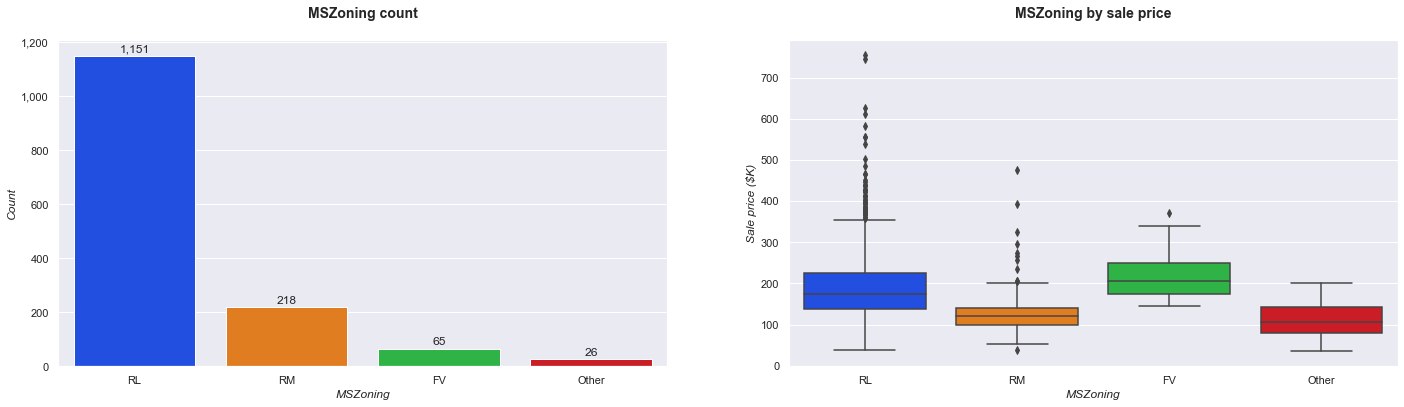

In [36]:
med_cat_var = cat_var_df[cat_var_df['SalePriceRange']>50000]
med_cat_var = med_cat_var['Variable'].tolist()
med_cat_var = [x for x in med_cat_var if x not in top_cat_var]
for variable in med_cat_var:
    if variable == 'Neighborhood': graph_overview(variable, variable, rotation=45, alignment='right')
    else: graph_overview(variable, variable)

In [37]:
cat_variables = cat_var_df[cat_var_df['SalePriceRange']>50000]
cat_variables = cat_variables['Variable'].tolist()
print("Number of categorical variables is:",len(cat_variables))

Number of categorical variables is: 19


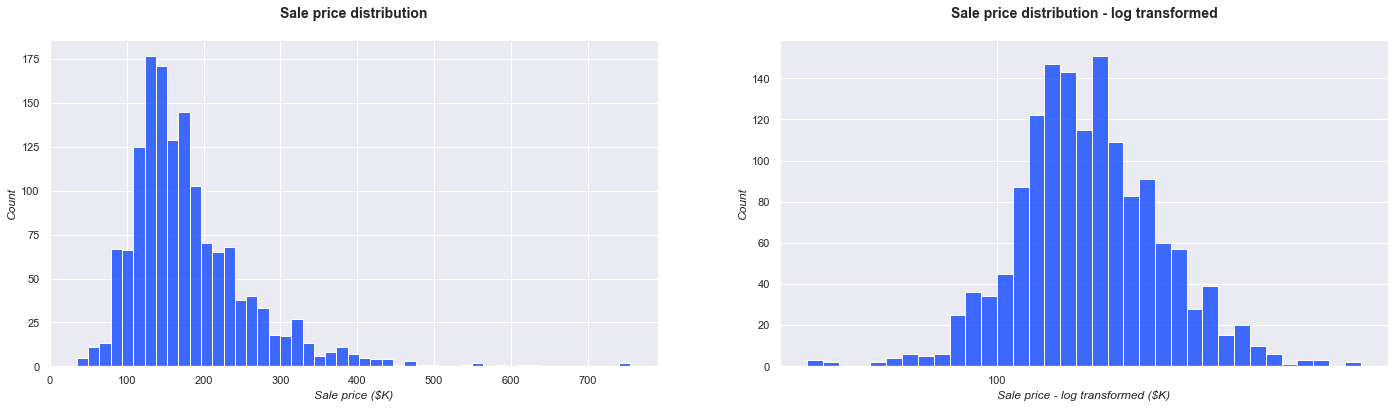

In [38]:
# Setting up the initial charts:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))  # sharex=True

graph1 = sns.histplot(x=df['SalePrice'], ax=ax1)
graph2 = sns.histplot(x=df['SalePrice'], ax=ax2, log_scale=True)

# Setting up axis 1
ax1.set_title("Sale price distribution\n", fontsize=14, fontweight='bold')
ax1.set_xlabel("Sale price ($K)", fontproperties=font)
ax1.set_ylabel('Count', fontproperties=font);
x_tick_labels_1 = ax1.get_xticks().tolist() # Setting the y-tick labels
ax1.xaxis.set_major_locator(mticker.FixedLocator(x_tick_labels_1)) # Setting the x-tick label locations
ax1.set_xticklabels(["{:,.0f}".format(x/1000) for x in x_tick_labels_1]); # Setting the x-label format

# Setting up axis 2
ax2.set_title("Sale price distribution - log transformed\n", fontsize=14, fontweight='bold')
ax2.set_xlabel("Sale price - log transformed ($K)", fontproperties=font)
ax2.set_ylabel('Count', fontproperties=font);
x_tick_labels_2 = ax2.get_xticks().tolist() # Setting the y-tick labels
ax2.xaxis.set_major_locator(mticker.FixedLocator(x_tick_labels_2)) # Setting the x-tick label locations
ax2.set_xticklabels(["{:,.0f}".format(x/1000) for x in x_tick_labels_2]); # Setting the x-label format

In [39]:
log_transform_target = False
nn_log_transform_target = False

In [40]:
def scale_data_and_define_features(df=df, scale_data=True, incl_target=True, 
                                   num_variables=num_variables, cat_variables=cat_variables):
    """
    Function to create our variables for training and testing via scaling
    """
    # Scaling the data
    scaler = MinMaxScaler()

    # Defining our model features:
    model_features = [*num_variables, *cat_variables]

    # Find variables not in model_features:
    to_drop = []
    for column in df.columns:
        if column not in model_features: to_drop.append(column)
    
    # Remove sale price and then drop from the df
    if incl_target: to_drop.remove('SalePrice')
    df.drop(to_drop, axis=1, inplace=True)

    # Defining our target:
    if incl_target: 
        if log_transform_target and nn_log_transform_target: 
            y = np.log(df['SalePrice'])
            y_nn = np.log(df['SalePrice'])
        elif nn_log_transform_target: 
            y = df['SalePrice']
            y_nn = np.log(df['SalePrice'])
        else: y = y_nn = df['SalePrice']

    # Scaling the feature data:
    if scale_data:
        X_num = pd.DataFrame(data=scaler.fit_transform(df[num_variables]), columns=num_variables)
        X = pd.concat([X_num, df[cat_variables]], axis=1, join="outer", ignore_index=False)
    else:
        X = df[model_features]
    
    if incl_target: return X, y, y_nn, df, model_features
    else: return X, df, model_features

X, y, y_nn, df, model_features = scale_data_and_define_features(df=df, scale_data=True)

In [41]:
# Defining our random state:
random_state = 42
# Setting our train:test split
test_size = 0.3
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size,random_state=random_state)
#if nn_log_transform_target: 
X_train, X_val, y_train_nn, y_val_nn = train_test_split(X, y_nn, test_size=test_size,random_state=random_state)

In [42]:
# One hot encoding:
X_ohe = pd.get_dummies(X.copy(), columns = cat_variables, prefix = cat_variables)
X_train_ohe = pd.get_dummies(X_train.copy(), columns = cat_variables, prefix = cat_variables)
X_val_ohe = pd.get_dummies(X_val.copy(), columns = cat_variables, prefix = cat_variables)

In [43]:
# 1. Cross validate model with Kfolds
folds = 5
kfold = KFold(n_splits=folds, shuffle=True, random_state=random_state)

# 2. Switches
models_dict = {"CatBoost": True, 
               "XGBoost": True, 
               "LightGBM": True, 
               "GradientBoosting": True, 
               "MLP": True, 
               "LDA": True, 
               "AdaBoost": True, 
               "LogReg": True, 
               "SVR": True, 
               "Ridge": True, 
               "Lasso": True, 
               "RandomForest": True,
              }

# 3. List of accuracies
accuracies = []
regressors = {}
models = {}
model_list = []

# 4. Trials list
trials_dict = {"CatBoost": 50, "XGBoost": 100, "LightGBM": 500, "GradientBoosting": 100, "MLP": 100, "LDA": 100, 
               "AdaBoost": 100, "LogReg": 50, "SVR": 500, "Ridge": 100, "Lasso": 100, "RandomForest": 50,
               "ensemble": 50, "Pytorch": 10}

# 5. Turning off the warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [44]:
# Switch for CatBoost using OHE or categorical features:
cb_ohe = True

# Setting the pools for training and testing
if cb_ohe: 
    pool_train = Pool(X_train_ohe, y_train, cat_features = None)
    pool_val = Pool(X_val_ohe, y_val, cat_features = None)
    X_val_cb = X_val_ohe
else:
    pool_train = Pool(X_train, y_train, cat_features = cat_variables)
    pool_val = Pool(X_val, y_val, cat_features = cat_variables)
    X_val_cb = X_val

# Setting the hyperparameters
cb_params = {
    "iterations": 10000,
    "learning_rate": 0.01,
    "loss_function": 'RMSE',
    "eval_metric": 'RMSE',
    "random_state": random_state,
}

cb_fit_params = {
    "eval_set": pool_val,
    "plot": False,
    "use_best_model": True,
    "verbose": False,
    "early_stopping_rounds": 200,
}

In [45]:
def cb_tune(trial):
    # Setting the hyperparameters
    cb_params = {
        "learning_rate": trial.suggest_uniform('learning_rate', 0.0000001, 0.1),
        "depth": trial.suggest_int("depth", 2, 8),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 9),
        "min_child_samples": trial.suggest_int("min_child_samples", 0, 9),
        "iterations": 10000,
        "random_state": random_state,
        "loss_function": 'RMSE',
    }
    
    # Setting up the model, fitting it and making our predictions:
    cb_model = CatBoostRegressor(**cb_params)
    cb_model.fit(pool_train, **cb_fit_params)
    cb_pred = cb_model.predict(X_val_cb)    
    if log_transform_target: cb_acc = rmse(actual=np.exp(y_val), predicted=np.exp(cb_pred))
    else: cb_acc = rmse(actual=y_val, predicted=cb_pred)
    return cb_acc

# Create and optimise the study
cb_study = optuna.create_study()
if models_dict['CatBoost']: 
    cb_study.optimize(cb_tune, n_trials=trials_dict['CatBoost'], show_progress_bar=True)
    cb_acc = cb_study.best_trial.value
    print('Best trial score: ${:,.0f}\nwith parameters: {}'
          .format(cb_study.best_trial.value, cb_study.best_trial.params)+"\n")
    
    # Setting up the regressor:
    cb_params = cb_study.best_params
    cb_model = CatBoostRegressor(**cb_params, random_state=random_state, verbose=False)
    cb_model.fit(pool_train, **cb_fit_params)
    cb_pred = cb_model.predict(X_val_cb)

    # Calculating model score:
    if log_transform_target: cb_acc = rmse(actual=np.exp(y_val), predicted = np.exp(cb_pred))
    else: cb_acc = rmse(actual=y_val, predicted = cb_pred)
    print("Tuned CatBoost model RMSE is: $"+str("{:,.0f}".format(cb_acc)))
    print("Tuned CatBoost model percentage error is: "+str("{:,.5f}".format(cb_acc/y_val.mean())))
    
    # Adding the scores and regressions to our lists:
    accuracies.append(cb_acc)
    regressors["CatBoost"] = CatBoostRegressor(**cb_params, random_state=random_state, verbose=False)
    models["CatBoost"] = cb_model
    model_list.append(cb_model)

c:\python\python39\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Best trial score: $24,489
with parameters: {'learning_rate': 0.02046086564761683, 'depth': 5, 'l2_leaf_reg': 6, 'min_child_samples': 8}

Tuned CatBoost model RMSE is: $24,940
Tuned CatBoost model percentage error is: 0.13855


In [46]:
def lgbm_tune(trial):
    # Setting the hyperparameters
    lgbm_params = {
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "num_leaves": trial.suggest_int("num_leaves", 2, 3000),
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "learning_rate": trial.suggest_uniform('learning_rate', 0.0000001, 0.1),
        "min_child_samples": trial.suggest_int('min_child_samples', 3, 200),
        "random_state": random_state,
        "verbose": -1,
    }
    
    # Setting the fitting parameters
    lgbm_fit_params = {
        "X": X_train_ohe, 
        "y": y_train, 
        "eval_set": (X_val_ohe, y_val), 
        "eval_metric": "rmse",
        "verbose": -1,
    }
    
    # Setting up our model
    lgbm_model = LGBMRegressor(**lgbm_params)
    
    # Setting up the model, fitting it and making our predictions:
    lgbm_model.fit(**lgbm_fit_params)
    lgbm_pred = lgbm_model.predict(X_val_ohe)
    if log_transform_target: lgbm_acc = rmse(actual = np.exp(y_val), predicted = np.exp(lgbm_pred))
    else: lgbm_acc = rmse(actual = y_val, predicted = lgbm_pred)
    
    return lgbm_acc

if models_dict['LightGBM']: 
    # Create and optimise the study
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    lgbm_study = optuna.create_study()
    lgbm_study.optimize(lgbm_tune, n_trials=trials_dict["LightGBM"], show_progress_bar=True)
    print('Best trial score: ${:,.0f}\nwith parameters: {}'
          .format(lgbm_study.best_trial.value, lgbm_study.best_trial.params)+"\n")
    
    # Setting up the regressor:
    lgbm_params = lgbm_study.best_params
    lgbm_model = LGBMRegressor(**lgbm_params, random_state=random_state)
    lgbm_model.fit(X_train_ohe, y_train)
    lgbm_pred = lgbm_model.predict(X_val_ohe)

    # Calculating model score:
    if log_transform_target: lgbm_acc = rmse(actual=np.exp(y_val), predicted=np.exp(lgbm_pred))
    else: lgbm_acc = rmse(actual=y_val, predicted=lgbm_pred)
    print("Tuned LightGBM model RMSE is: $"+str("{:,.0f}".format(lgbm_acc)))
    
    # Adding the scores and regressions to our lists:
    accuracies.append(lgbm_acc)
    regressors["LightGBM"] = LGBMRegressor(**lgbm_params)
    models["LightGBM"] = lgbm_model
    model_list.append(lgbm_model)

  0%|          | 0/500 [00:00<?, ?it/s]

Best trial score: $25,811
with parameters: {'max_depth': 3, 'num_leaves': 2834, 'n_estimators': 898, 'learning_rate': 0.02227981053201486, 'min_child_samples': 3}

Tuned LightGBM model RMSE is: $25,811


In [47]:
# Setting up the model:
def xgb_tune(trial):
    # List of hyperparameters to try:
    boosting_list = ['gbtree', 'gblinear']
    
    xgb_params = {
        #"boosting_type": trial.suggest.categorical("boosting_type", boosting_list)
        "n_estimators": trial.suggest_int('n_estimators', 100, 2000),
        "max_depth": trial.suggest_int('max_depth', 2, 15),
        "reg_alpha": trial.suggest_int('reg_alpha', 0, 5),
        "reg_lambda": trial.suggest_int('reg_lambda', 0, 5), 
        "gamma": trial.suggest_int('gamma', 0, 5),
        "learning_rate": trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        "colsample_bytree": trial.suggest_discrete_uniform('colsample_bytree', 0.1, 1, 0.01),
        "subsample": trial.suggest_discrete_uniform('subsample', 0.6, 0.9, 0.1),
        "eval_metric": 'rmse',
        "objective": 'reg:squarederror',
        "use_label_encoder": False, 
        "random_state": random_state,
    }  
    
    # Set up the model:
    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(X_train_ohe, y_train)
    xgb_pred = xgb_model.predict(X_val_ohe)
    
    # Calculate the accuracy
    if log_transform_target: xgb_acc = rmse(actual = np.exp(y_val), predicted = np.exp(xgb_pred))
    else: xgb_acc = rmse(actual = y_val, predicted = xgb_pred)
    
    return xgb_acc

if models_dict['XGBoost']: 
    # Create and optimise the study:
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    xgb_study = optuna.create_study()
    xgb_study.optimize(xgb_tune, n_trials=trials_dict['XGBoost'], show_progress_bar=True)
    xgb_acc = xgb_study.best_trial.value
    print('Best trial score: ${:,.0f}\nwith parameters: {}'.format(
        xgb_study.best_trial.value, xgb_study.best_trial.params)+"\n")
    
    # Setting up the regressor:
    xgb_params = xgb_study.best_params
    xgb_model = XGBRegressor(**xgb_params, random_state=random_state)
    xgb_model.fit(X_train_ohe, y_train)
    xgb_pred = xgb_model.predict(X_val_ohe)

    # Calculating model score:
    if log_transform_target: xgb_acc = rmse(actual=np.exp(y_val), predicted=np.exp(xgb_pred))
    else: xgb_acc = rmse(actual=y_val, predicted=xgb_pred)
    print("Tuned XGBoost model RMSE is: $"+str("{:,.0f}".format(xgb_acc)))
    
    # Adding the scores and regressions to our lists:
    accuracies.append(xgb_acc)
    regressors["XGBoost"] = XGBRegressor(**xgb_params)
    models["XGBoost"] = xgb_model
    model_list.append(xgb_model)

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial score: $24,189
with parameters: {'n_estimators': 1399, 'max_depth': 3, 'reg_alpha': 2, 'reg_lambda': 0, 'gamma': 1, 'learning_rate': 0.01798386053525652, 'colsample_bytree': 0.43000000000000005, 'subsample': 0.9}

Tuned XGBoost model RMSE is: $24,189


In [48]:
def gbr_tune(trial):
    # Setting our hyperparameters
    gbr_params = {
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "n_estimators": trial.suggest_int("n_estimators", 1, 300),
        "learning_rate": trial.suggest_uniform('learning_rate', 0.00001, 1),
        "min_samples_leaf": trial.suggest_int('min_samples_leaf', 1, 19, 3),
        "max_features": trial.suggest_uniform('max_features', 0.1, 1.0),
        "random_state": random_state
    }
    
    # Setting up our model:
    gbr = GradientBoostingRegressor(**gbr_params)
    gbr.fit(X_train_ohe, y_train)
    gbr_pred = gbr.predict(X_val_ohe)

    # Calculating model scores:
    if log_transform_target: gbr_acc = rmse(actual = np.exp(y_val), predicted = np.exp(gbr_pred))
    else: gbr_acc = rmse(actual = y_val, predicted = gbr_pred)

    return gbr_acc

if models_dict['GradientBoosting']: 
    # Turning off the warnings
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    # Create and optimise the study
    gbr_study = optuna.create_study()
    gbr_study.optimize(gbr_tune, n_trials=trials_dict['GradientBoosting'], show_progress_bar=True)
    gbr_acc = gbr_study.best_trial.value
    print('Best trial score: ${:,.0f}\nwith parameters: {}'.format(
        gbr_study.best_trial.value, gbr_study.best_trial.params)+"\n")
    
    # Setting up the regressor:
    gbr_params = gbr_study.best_params
    gbr_model = GradientBoostingRegressor(**gbr_params, random_state=random_state)
    gbr_model.fit(X_train_ohe, y_train)
    gbr_pred = gbr_model.predict(X_val_ohe)

    # Calculating model score:
    if log_transform_target: gbr_acc = rmse(actual=np.exp(y_val), predicted=np.exp(gbr_pred))
    else: gbr_acc = rmse(actual=y_val, predicted=gbr_pred)
    print("Tuned Gradient Boosting model RMSE is: $"+str("{:,.0f}".format(gbr_acc)))
    
    # Adding the scores and regressions to our lists:
    accuracies.append(gbr_acc)
    regressors["GradientBoosting"] = GradientBoostingRegressor(**gbr_params)
    models["GradientBoosting"] = gbr_model
    model_list.append(gbr_model)

  0%|          | 0/100 [00:00<?, ?it/s]

Best trial score: $25,436
with parameters: {'max_depth': 4, 'n_estimators': 261, 'learning_rate': 0.06341645759873629, 'min_samples_leaf': 7, 'max_features': 0.2862595401177474}

Tuned Gradient Boosting model RMSE is: $25,436


In [49]:
def mlp_tune(trial):
    mlp_params = {
        "learning_rate_init": trial.suggest_uniform("learning_rate_init", 0.01, 0.5),
        "hidden_layer_sizes": trial.suggest_int('hidden_layer_sizes', 8, 126),
        "max_iter": trial.suggest_int('max_iter', 1000, 5000),
        "random_state": random_state,
    }
    
    # Setting up the regressor:
    mlp = MLPRegressor(**mlp_params)
    mlp.fit(X_train_ohe, y_train)
    mlp_pred = mlp.predict(X_val_ohe)

    # Calculating model scores:
    if log_transform_target: mlp_acc = rmse(actual = np.exp(y_val), predicted = np.exp(mlp_pred))
    else: mlp_acc = rmse(actual = y_val, predicted = mlp_pred)

    return mlp_acc

if models_dict['MLP']: 
    # Create and optimise the study
    mlp_study = optuna.create_study()
    mlp_study.optimize(mlp_tune, n_trials=trials_dict['MLP'], show_progress_bar=True)
    mlp_acc = mlp_study.best_trial.value
    print('Best trial score: ${:,.0f}\nwith parameters: {}'.format(mlp_study.best_trial.value, mlp_study.best_trial.params)+"\n")
    
    # Setting up the regressor:
    mlp_params = mlp_study.best_params
    mlp_model = MLPRegressor(**mlp_params, random_state=random_state)
    mlp_model.fit(X_train_ohe, y_train)
    mlp_pred = mlp_model.predict(X_val_ohe)

    # Calculating model score:
    if log_transform_target: mlp_acc = rmse(actual=np.exp(y_val), predicted=np.exp(mlp_pred))
    else: mlp_acc = rmse(actual=y_val, predicted=mlp_pred)
    print("Tuned MLP model RMSE is: $"+str("{:,.0f}".format(mlp_acc)))
    
    # Adding the scores and regressions to our lists:
    accuracies.append(mlp_acc)
    regressors["MLP"] = MLPRegressor(**mlp_params)
    models["MLP"] = mlp_model
    model_list.append(mlp_model)

c:\python\python39\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Best trial score: $29,711
with parameters: {'learning_rate_init': 0.3895083753432426, 'hidden_layer_sizes': 109, 'max_iter': 4535}

Tuned MLP model RMSE is: $29,711


In [50]:
if models_dict['LDA']: 
    # Instantiate and fit our model
    lda_model = LinearDiscriminantAnalysis()
    lda_model.fit(X_train_ohe, y_train)
    lda_pred = lda_model.predict(X_val_ohe)

    # Calculating model score:
    if log_transform_target: lda_acc = rmse(actual=np.exp(y_val), predicted=np.exp(lda_pred))
    else: lda_acc = rmse(actual=y_val, predicted=lda_pred)
    print("LDA model RMSE is: $"+str("{:,.0f}".format(lda_acc)))
    
    # Adding the scores and regressions to our lists:
    accuracies.append(lda_acc)
    regressors["LDA"] = LinearDiscriminantAnalysis()
    models["LDA"] = lda_model
    model_list.append(lda_model)

LDA model RMSE is: $41,446


In [51]:
if models_dict['LogReg']: 
    # Instantiate the model
    logreg_model = LogisticRegression(random_state=random_state, max_iter=2000)
    logreg_model.fit(X_train_ohe, y_train)
    logreg_pred = logreg_model.predict(X_val_ohe)

    # Calculating model score:
    if log_transform_target: logreg_acc = rmse(actual=np.exp(y_val), predicted=np.exp(logreg_pred))
    else: logreg_acc = rmse(actual=y_val, predicted=logreg_pred)
    print("Logistic regression model RMSE is: $"+str("{:,.0f}".format(logreg_acc)))
    
    # Adding the scores and regressions to our lists:
    accuracies.append(logreg_acc)
    regressors["LogReg"] = LogisticRegression(random_state=random_state, max_iter=2000)
    models["LogReg"] = logreg_model
    model_list.append(logreg_model)

Logistic regression model RMSE is: $45,691


In [52]:
def ada_tune(trial):
    # Setting our hyperparameters
    ada_losses = ['linear', 'square', 'exponential']
    ada_params = {
        "loss": trial.suggest_categorical("loss", ada_losses),
        "n_estimators": trial.suggest_int("n_estimators", 25, 100),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 1),
        "random_state": random_state,
    }
    
    ada_model = AdaBoostRegressor(**ada_params)
    ada_model.fit(X_train_ohe, y_train)
    ada_pred = ada_model.predict(X_val_ohe)
    ada_acc = rmse(y_val, ada_pred)
    return ada_acc

if models_dict['AdaBoost']: 
    # Create and optimise the study
    ada_study = optuna.create_study()
    ada_study.optimize(ada_tune, n_trials=trials_dict['AdaBoost'], show_progress_bar=True)
    ada_acc = ada_study.best_trial.value
    print('Best trial score: ${:,.0f}\nwith parameters: {}'.format(
        ada_study.best_trial.value, ada_study.best_trial.params)+"\n")
    
    # Setting up the regressor:
    ada_params = ada_study.best_params
    ada_model = AdaBoostRegressor(**ada_params, random_state=random_state)
    ada_model.fit(X_train_ohe, y_train)
    ada_pred = ada_model.predict(X_val_ohe)

    # Calculating model score:
    if log_transform_target: ada_acc = rmse(actual=np.exp(y_val), predicted=np.exp(ada_pred))
    else: ada_acc = rmse(actual=y_val, predicted=ada_pred)
    print("Tuned AdaBoost model RMSE is: $"+str("{:,.0f}".format(ada_acc)))
    
    # Adding the scores and regressions to our lists:
    accuracies.append(ada_acc)
    regressors["AdaBoost"] = AdaBoostRegressor(**ada_params)
    models["AdaBoost"] = ada_model
    model_list.append(ada_model)

c:\python\python39\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Best trial score: $30,592
with parameters: {'loss': 'exponential', 'n_estimators': 83, 'learning_rate': 0.3918247188252452}

Tuned AdaBoost model RMSE is: $30,592


In [53]:
def svr_tune(trial):
    # Setting our hyperparameters:
    svr_kernels = ["linear", "poly", "rbf", "sigmoid"]
    
    svr_params = {
        "kernel": trial.suggest_categorical("kernel", svr_kernels),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "degree": trial.suggest_int("degree", 2, 5),
        "max_iter": trial.suggest_int("max_iter", 1000, 5000),
        "epsilon": trial.suggest_uniform("epsilon", 0.01, 1),
        "tol": trial.suggest_uniform("tol", 0.01, 500),
        "C": trial.suggest_uniform("C", 0.5, 10),
        "verbose": False, 
    }
    
    # Setting up the regressor:
    svr = SVR(**svr_params)
    svr.fit(X_train_ohe, y_train)
    svr_pred = svr.predict(X_val_ohe)

    # Calculate the scores
    svr_acc = rmse(y_val, svr_pred)

    return svr_acc

if models_dict['SVR']: 
    # Create and optimise the study
    svr_study = optuna.create_study()
    svr_study.optimize(svr_tune, n_trials=trials_dict['SVR'], show_progress_bar=True)
    svr_acc = svr_study.best_trial.value
    print('Best trial score: ${:,.0f}\nwith parameters: {}'.format(
        svr_study.best_trial.value, svr_study.best_trial.params)+"\n")
    
    # Setting up the regressor:
    svr_params = svr_study.best_params
    svr_model = SVR(**svr_params)
    svr_model.fit(X_train_ohe, y_train)
    svr_pred = svr_model.predict(X_val_ohe)

    # Calculating model score:
    if log_transform_target: svr_acc = rmse(actual=np.exp(y_val), predicted=np.exp(svr_pred))
    else: svr_acc = rmse(actual=y_val, predicted=svr_pred)
    print("Tuned SVR model RMSE is: $"+str("{:,.0f}".format(svr_acc)))
    
    # Adding the scores and regressions to our lists:
    accuracies.append(svr_acc)
    regressors["SVR"] = SVR(**svr_params)
    models["SVR"] = svr_model
    model_list.append(svr_model)

c:\python\python39\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/500 [00:00<?, ?it/s]

Best trial score: $75,531
with parameters: {'kernel': 'linear', 'shrinking': True, 'degree': 2, 'max_iter': 2089, 'epsilon': 0.7291330208826632, 'tol': 336.7876864097322, 'C': 9.999681656654712}

Tuned SVR model RMSE is: $75,531


In [54]:
def ridge_tune(trial):
    ridge_params = {
        "alpha": trial.suggest_float("alpha", 0.001, 1),
        "tol": trial.suggest_float("tol", 0.1, 0.9),
        "random_state": random_state,
    }
    
    # Setting up the regressor:
    ridge = Ridge(**ridge_params)
    ridge.fit(X_train_ohe, y_train)
    ridge_pred = ridge.predict(X_val_ohe)

    # Calculate the scores
    ridge_acc = rmse(y_val, ridge_pred)

    return ridge_acc

if models_dict['Ridge']: 
    # Create and optimise the study
    ridge_study = optuna.create_study()
    ridge_study.optimize(ridge_tune, n_trials=trials_dict['Ridge'], show_progress_bar=True)
    ridge_acc = ridge_study.best_trial.value
    print('Best trial score: ${:,.0f}\nwith parameters: {}'.format(
        ridge_study.best_trial.value, ridge_study.best_trial.params)+"\n")
    
    # Setting up the regressor:
    ridge_params = ridge_study.best_params
    ridge_model = Ridge(**ridge_params)
    ridge_model.fit(X_train_ohe, y_train)
    ridge_pred = ridge_model.predict(X_val_ohe)

    # Calculating model score:
    if log_transform_target: ridge_acc = rmse(actual=np.exp(y_val), predicted=np.exp(ridge_pred))
    else: ridge_acc = rmse(actual=y_val, predicted=ridge_pred)
    print("Tuned Ridge model RMSE is: $"+str("{:,.0f}".format(ridge_acc)))
    
    # Adding the scores and regressions to our lists:
    accuracies.append(ridge_acc)
    regressors["Ridge"] = Ridge(**ridge_params)
    models["Ridge"] = ridge_model
    model_list.append(ridge_model)

c:\python\python39\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Best trial score: $29,593
with parameters: {'alpha': 0.9995607870751883, 'tol': 0.284604203403612}

Tuned Ridge model RMSE is: $29,593


In [55]:
def lasso_tune(trial):
    lasso_params = {
        "alpha": trial.suggest_float("alpha", 0.01, 1),
        "max_iter": trial.suggest_int("max_iter", 10000, 50000),
        "random_state": random_state,
    }
    
    # Setting up the regressor:
    lasso = Lasso(**lasso_params)
    lasso.fit(X_train_ohe, y_train)
    lasso_pred = lasso.predict(X_val_ohe)

    # Calculate the scores
    lasso_acc = rmse(y_val, lasso_pred)

    return lasso_acc

if models_dict['Lasso']: 
    # Create and optimise the study
    lasso_study = optuna.create_study()
    lasso_study.optimize(lasso_tune, n_trials=trials_dict['Lasso'], show_progress_bar=True)
    lasso_acc = lasso_study.best_trial.value
    print('Best trial score: ${:,.0f}\nwith parameters: {}'.format(
        lasso_study.best_trial.value, lasso_study.best_trial.params)+"\n")
    
    # Setting up the regressor:
    lasso_params = lasso_study.best_params
    lasso_model = Lasso(**lasso_params)
    lasso_model.fit(X_train_ohe, y_train)
    lasso_pred = lasso_model.predict(X_val_ohe)

    # Calculating model score:
    if log_transform_target: lasso_acc = rmse(actual=np.exp(y_val), predicted=np.exp(lasso_pred))
    else: lasso_acc = rmse(actual=y_val, predicted=lasso_pred)
    print("Tuned Lasso model RMSE is: $"+str("{:,.0f}".format(lasso_acc)))
    
    # Adding the scores and regressions to our lists:
    accuracies.append(lasso_acc)
    regressors["Lasso"] = Lasso(**lasso_params)
    models["Lasso"] = lasso_model
    model_list.append(lasso_model)

c:\python\python39\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

c:\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92910514588.95831, tolerance: 615098412.8205525
  model = cd_fast.enet_coordinate_descent(
c:\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92907926155.2771, tolerance: 615098412.8205525
  model = cd_fast.enet_coordinate_descent(


Best trial score: $29,713
with parameters: {'alpha': 0.9999065183562582, 'max_iter': 23678}

Tuned Lasso model RMSE is: $29,713


In [56]:
def rf_tune(trial):
    rf_params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 5, 12),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 3, 6),
        "max_features": trial.suggest_int("max_features", 5, 126),
        "random_state": random_state,
    }
    
    # Setting up the regressor:
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train_ohe, y_train)
    rf_pred = rf.predict(X_val_ohe)

    # Calculate the scores
    rf_acc = rmse(y_val, rf_pred)

    return rf_acc

if models_dict['RandomForest']: 
    # Create and optimise the study
    rf_study = optuna.create_study()
    rf_study.optimize(rf_tune, n_trials=trials_dict['Lasso'], show_progress_bar=True)
    rf_acc = rf_study.best_trial.value
    print('Best trial score: ${:,.0f}\nwith parameters: {}'.format(
        rf_study.best_trial.value, rf_study.best_trial.params)+"\n")
    # Setting up the regressor:
    rf_params = rf_study.best_params
    rf_model = RandomForestRegressor(**rf_params)
    rf_model.fit(X_train_ohe, y_train)
    rf_pred = rf_model.predict(X_val_ohe)

    # Calculating model score:
    if log_transform_target: rf_acc = rmse(actual=np.exp(y_val), predicted=np.exp(rf_pred))
    else: rf_acc = rmse(actual=y_val, predicted=rf_pred)
    print("Tuned random forest model RMSE is: $"+str("{:,.0f}".format(rf_acc)))
    
    # Adding the scores and regressions to our lists:
    accuracies.append(rf_acc)
    regressors["RandomForest"] = RandomForestRegressor(**rf_params)
    models["RandomForest"] = rf_model
    model_list.append(rf_model)

c:\python\python39\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

Best trial score: $28,014
with parameters: {'n_estimators': 171, 'max_depth': 12, 'min_samples_leaf': 3, 'max_features': 81}

Tuned random forest model RMSE is: $28,621


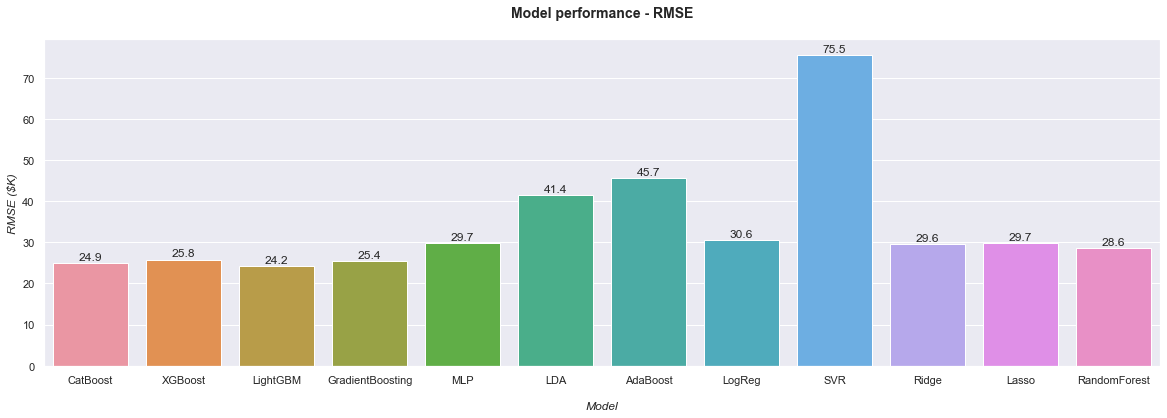

In [57]:
# Models to compare:
model_names = []
for model, boolean in models_dict.items():
    if boolean: model_names.append(model)

accuracies = np.array(accuracies)

# Draw the bar charts
draw_bar_chart(x=model_names, y=accuracies, title="Model performance - RMSE\n", x_axis_label="\nModel", x_tick_rotation=0, 
               y_axis_label="RMSE ($K)", y_scaling=1000, add_num_labels=True, figsize=(20,6), label_format="{:,.1f}",
               num_labels=accuracies/1000, legend=None, #y_axis_limits=(0,45000)
              );

In [58]:
%%time

# Appending each classifier's results to a list
cv_results = []
for model, regressor in regressors.items():
    cv_results.append(-cross_val_score(regressor, X=X_ohe, y=y, scoring="neg_root_mean_squared_error", 
                                       cv=kfold, n_jobs=-1, verbose=0))
    print("Cross-validation complete for: \t"+str(model))

# Calculating the mean performance and standard deviation for comparison later:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CV_means":cv_means,"CV_std": cv_std,"Model":model_names})

Cross-validation complete for: 	CatBoost
Cross-validation complete for: 	LightGBM
Cross-validation complete for: 	XGBoost
Cross-validation complete for: 	GradientBoosting
Cross-validation complete for: 	MLP
Cross-validation complete for: 	LDA
Cross-validation complete for: 	LogReg
Cross-validation complete for: 	AdaBoost
Cross-validation complete for: 	SVR
Cross-validation complete for: 	Ridge
Cross-validation complete for: 	Lasso
Cross-validation complete for: 	RandomForest
Wall time: 2min 8s


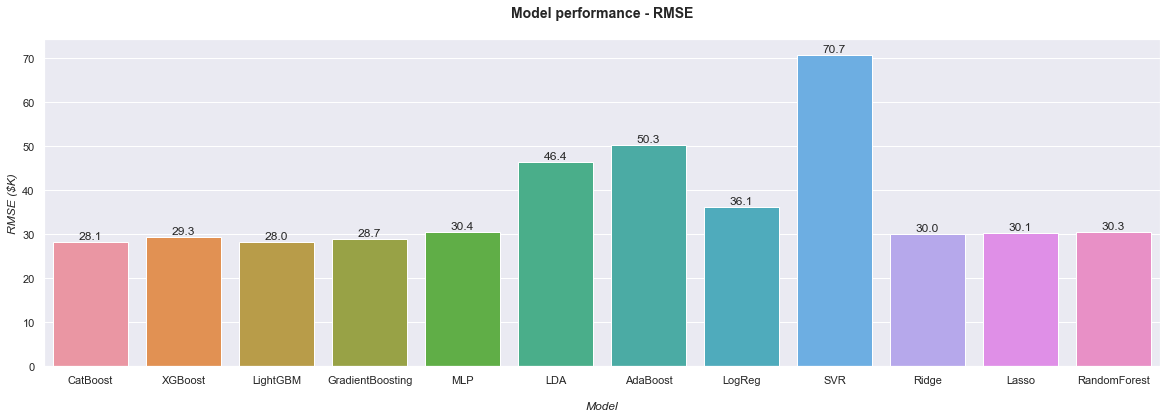

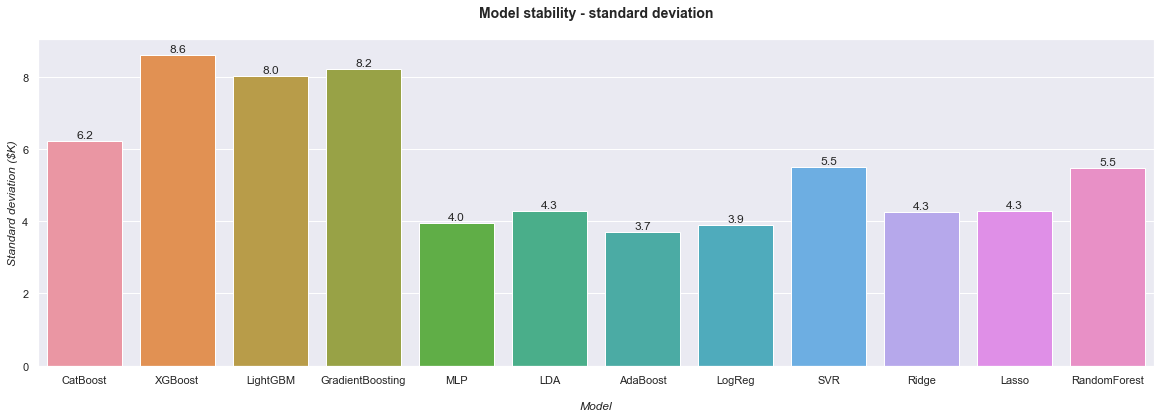

In [59]:
draw_bar_chart(x=cv_res["Model"], y=cv_res["CV_means"], title="Model performance - RMSE\n", 
               x_axis_label="\nModel", x_tick_rotation=0, y_axis_label="RMSE ($K)", y_scaling=1000,
               add_num_labels=True, figsize=(20,6), label_format="{:,.1f}",
               num_labels=cv_res["CV_means"]/1000, legend=None, #y_axis_limits=(20e3,80e3)
              );
draw_bar_chart(x=cv_res["Model"], y=cv_res["CV_std"], title="Model stability - standard deviation\n", 
               x_axis_label="\nModel", x_tick_rotation=0, y_axis_label="Standard deviation ($K)", y_scaling=1000,
               add_num_labels=True, figsize=(20,6), label_format="{:,.1f}",
               num_labels=cv_res["CV_std"]/1000, legend=None, #y_axis_limits=(3e3,8.5e3)
              );

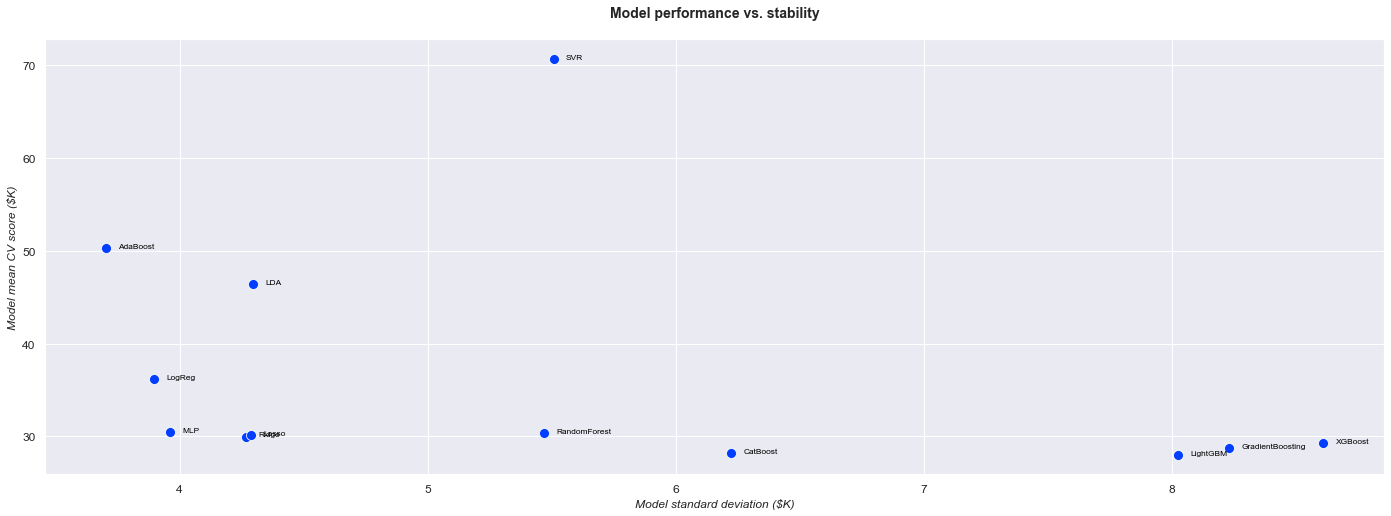

In [60]:
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    # Creating the figure:
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(24,8))

    # Create the scatter plot    
    p1 = sns.scatterplot(x=x, y=y, data=data, ax=ax, s=100, legend=False)
    
    # Set title
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Creating the axis labels:
    ax.set_xlabel(xlabel, fontproperties=font)
    ax.set_ylabel(ylabel, fontproperties=font)
    
    # Setting label ticks size:
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    
    # Formatting the y-axis labels
    y_tick_loc = ax.get_yticks().tolist() # Setting the y-tick labels
    ax.yaxis.set_major_locator(mticker.FixedLocator(y_tick_loc))
    ax.set_yticklabels(["{:,.0f}".format(x/1000) for x in y_tick_loc])

    # Formatting the y-axis labels
    x_tick_loc = ax.get_xticks().tolist() # Setting the x-tick labels
    ax.xaxis.set_major_locator(mticker.FixedLocator(x_tick_loc))
    ax.set_xticklabels(["{:,.0f}".format(x/1000) for x in x_tick_loc])

    # Add text besides each point
    for line in range(0,data.shape[0]):
         p1.text(data[x][line]+50, data[y][line], 
                 data[text_column][line], 
                 horizontalalignment='left', 
                 size='small', 
                 color='black',
                )    
    return p1

# Draw the scatter chart:
scatter_text(x='CV_std', 
             y='CV_means', 
             text_column='Model', 
             data=cv_res, 
             title='Model performance vs. stability\n', 
             ylabel='Model mean CV score ($K)',
             xlabel='Model standard deviation ($K)');

In [62]:
# Calling the test data:
test = pd.read_csv('test.csv')

# Saving the Id column for later:
Id = test['Id']

# Remove variables from the test dataframe that aren't model features:
for col in test.columns:
    if col not in df.columns:
        test.drop(col, axis=1, inplace=True)

# Removing the missing data from the test set:
removing_missing_data(df=test)
        
# Creating the z-scores in the test df to remove outliers:
outlier_cols_test, outliers_test, z_score_test = create_z_scores(df=test)

# Replacing the outliers with a value equal to a z-score of 3:
replace_outliers(outlier_cols=outlier_cols_test,num_variables =num_variables, outliers=outliers_test, df=test)

# remove variables from the categorical variables that were taken out above
for var in var_to_remove:
    if var in cat_variables: cat_variables.remove(var)

# Remove occurences of variables from the test set that have been removed from the df set already:
for idx, cat_var in enumerate(cat_variables):
    test_occurences = list(test[cat_variables[idx]].value_counts().keys())
    df_occurences = list(df[cat_variables[idx]].value_counts().keys())
    for test_occ in test_occurences:
        if test_occ in df_occurences:
            pass
        else:
            test[cat_var] = np.where(test[cat_var] == test_occ, 'Other', test[cat_var])

Dropping from the data: []


In [63]:
X_test, test, model_features = scale_data_and_define_features(df=test, scale_data=True, incl_target=False, num_variables=num_variables, cat_variables=cat_variables)

In [64]:
# Creating our one hot encoded variables:
X_test_ohe = pd.get_dummies(X_test, columns = cat_variables, prefix = cat_variables)
# Creating our predictions for each model:
predictions_df = pd.DataFrame()
for model, boolean in models_dict.items():
    if model == "CatBoost" and boolean:
        if cb_ohe: predictions_df[model] = cb_model.predict(X_test_ohe)
        else: predictions_df[model] = cb_model.predict(X_test)
    else:
        if boolean: predictions_df[model] = models[model].predict(X_test_ohe)

            # And transform them if that's what we want!
if log_transform_target: predictions_df = np.exp(predictions_df)

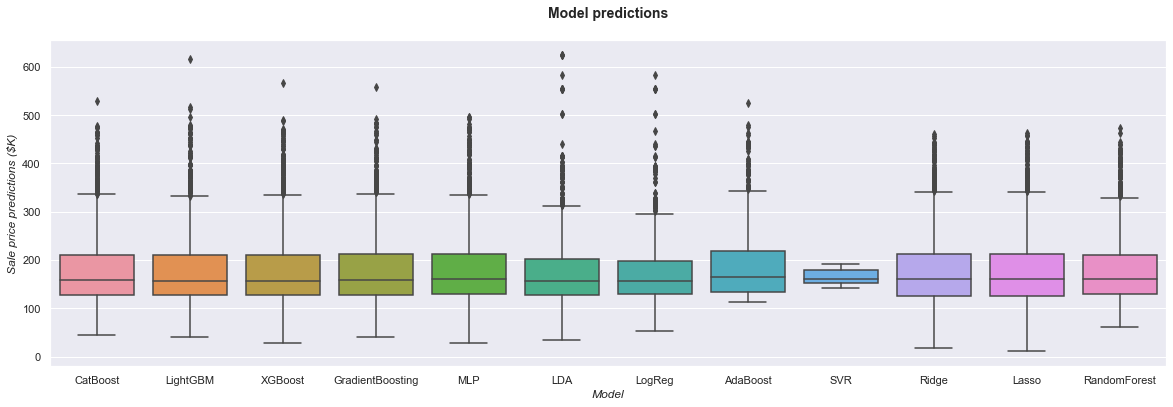

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6))
sns.boxplot(data=predictions_df[models]);
ax.set_title("Model predictions\n", fontsize=14, fontweight='bold')
ax.set_xlabel("Model", fontproperties=font)
ax.set_ylabel('Sale price predictions ($K)', fontproperties=font);
# Setting y-tick labels
y_tick_labels_1 = ax.get_yticks().tolist() # Setting the y-tick labels
ax.yaxis.set_major_locator(mticker.FixedLocator(y_tick_labels_1)) # Setting the y-tick label locations
ax.set_yticklabels(["{:,.0f}".format(x/1000) for x in y_tick_labels_1]); # Setting the y-label format

In [67]:
def scorer(actual, predicted):
    return rmse(actual=actual, predicted=predicted)

In [68]:
%%time

# Set up our superlearner with folds 
ensemble = SuperLearner(folds=folds, 
                        random_state=random_state, 
                        scorer=scorer,
                        #sample_size=len(X),
                        verbose=True,
                       )
ensemble.add(model_list)

# Adding our metalearner
ensemble.add_meta(LinearRegression())

# Now to fit the model on the training data
ensemble.fit(X_train_ohe, y_train)

# Make the predictions using the validation data:
ensemble_predictions = ensemble.predict(X_val_ohe)
ensemble_acc = rmse(actual = y_val, predicted = ensemble_predictions)
ensemble_per_cent = ensemble_acc/y_val.mean()
print("\nEnsemble model RMSE is: $"+str("{:,.0f}".format(ensemble_acc)))
print("Ensemble model percentage error is: "+str("{:,.5f}".format(ensemble_per_cent))+"\n")


Fitting 2 layers
Fit complete                        | 00:01:27

Predicting 2 layers
Predict complete                    | 00:00:00

Ensemble model RMSE is: $28,511
Ensemble model percentage error is: 0.15839

Wall time: 1min 28s


In [69]:
# Creating a dictionary of the models from which to refer when tuning the Superlearner
model_dict = {}
for idx, model in enumerate(model_names):
    model_dict[model] = model_list[idx]
    
# Setting up a dictionary of the possible head models:
head_dict = {'CatBoost': CatBoostRegressor(random_state=random_state, iterations=2000, verbose=False),
             "LinearRegression": LinearRegression(),
            }
def superlearner_tune(trial):
    # Setting up our blank model names
    models_to_add = []
    
    # List the models to use in the ensemble
    model_list = list(model_dict.keys())
    
    # List the models to be used in the head
    head_list = list(head_dict.keys())
    
    # Varying the number of models:
    n_models = trial.suggest_int("n_models", 2, len(model_list))
    for i in range(n_models):
        model_item = trial.suggest_categorical('model_{}'.format(i), model_list)
        if model_item not in models_to_add:
            models_to_add.append(model_item)
    
    # Instantiate the ensemble model:
    ensemble = SuperLearner(folds=folds, random_state=random_state, shuffle=False, 
                            scorer=scorer, sample_size=len(X))
    
    # Add all the models to the ensemble:
    models = [model_dict[item] for item in models_to_add]
    ensemble.add(models)
    
    # Cycle through possible 'heads'
    head = trial.suggest_categorical('head', head_list)
    ensemble.add_meta(head_dict[head])
        
    return ensemble

def objective(trial):
    model = superlearner_tune(trial)
    model.fit(X_ohe, y)
    sl_pred = model.predict(X_ohe)
    sl_acc = scorer(y, sl_pred)
    return sl_acc

In [70]:
%%time
# Creating our sampler
sampler = TPESampler(seed=random_state)

# creating the study:
ensemble_study = optuna.create_study(direction="minimize", sampler=sampler)

# Optimising our study:
ensemble_study.optimize(objective, n_trials=trials_dict['ensemble'], timeout=7200, show_progress_bar=True)

c:\python\python39\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Wall time: 49min 47s


In [71]:
# Define the best parameters of the study:
ensemble_params = ensemble_study.best_params
head = ensemble_params['head']
del ensemble_params['head'], ensemble_params['n_models']
ensemble_models = list()
for key, value in ensemble_params.items():
    if value not in ensemble_models:
        ensemble_models.append(value)

print("Head model is: "+str(head))
print("Component models are: "+str(ensemble_models))

Head model is: LinearRegression
Component models are: ['SVR', 'LightGBM', 'AdaBoost', 'Lasso', 'MLP']


In [72]:
model_structure_override = False
if model_structure_override:
    head = "LinearRegression"
    ensemble_models = ["Ridge", "Lasso", "AdaBoost", "MLP"]

In [73]:
%%time

# Instantiate our optimised ensemble model:
ensemble = SuperLearner(folds=folds, random_state=random_state)

# Add the models from the result above to the ensemble:
final_models = [model_dict[item] for item in ensemble_models]
ensemble.add(final_models)

# Add the meta model from the above:
ensemble.add_meta(head_dict[head])

# Fit the optimised ensemble model:
ensemble.fit(X_train_ohe, y_train)

# Make the final predictions:
ensemble_pred = ensemble.predict(X_val_ohe)

# Calculating model score:
if log_transform_target: ensemble_acc = rmse(actual=np.exp(y_val), predicted=np.exp(ensemble_pred))
else: ensemble_acc = rmse(actual=y_val, predicted=ensemble_pred)
print("Tuned ensemble model RMSE is: $"+str("{:,.0f}".format(ensemble_acc)))
print("Tuned ensemble model percentage error is: "+str("{:,.5f}".format(ensemble_acc/y_val.mean()))+"\n")

Tuned ensemble model RMSE is: $26,498
Tuned ensemble model percentage error is: 0.14721

Wall time: 1min 9s


In [74]:
ensemble_test_predictions = ensemble.predict(X_test_ohe)
submission = pd.DataFrame({"Id": Id, "SalePrice": ensemble_test_predictions})
submission.to_csv("ensemble_model_submission.csv", index=False)